In [154]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from tqdm import tqdm
import tensorflow as tf
import string

In [27]:
from tensorflow import keras
from tensorflow.keras import layers

In [53]:
chars = sorted(set(string.ascii_letters + string.digits))
char_to_int = dict((c, float(i)) for i, c in enumerate(chars))


def generate_image(text, fontsize=25, ha="center", va="center", width=256, height=256):
    dpi = 80 
    fig = Figure(figsize=(width/dpi, height/dpi), dpi=dpi)
    canvas = FigureCanvas(fig)

    ax = fig.gca()
    ax.text(0.5, 0.5, text, fontsize=fontsize, ha=ha, va=va)
    ax.axis('off')

    canvas.draw()

    data = np.frombuffer(canvas.tostring_rgb(), dtype=np.uint8)
    data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))

    grayscale_data = np.mean(data, axis=2)
    grayscale_data = grayscale_data[:, :, np.newaxis]
    return grayscale_data

def preprocess(char):
    return np.array([char_to_int[char]])

def generator():
    font_sizes = list(range(10, 26, 2))
    ha = ["center", "left", "right"]
    va = ["center", "top", "bottom"]
    for char in chars:
        for f_i, font_size in enumerate(font_sizes):
            for h_i, ha_al in enumerate(ha):
                for v_i, va_al in enumerate(va):
                    x = np.array([
                        char_to_int[char] / float(len(char_to_int) + 1), 
                        f_i / len(font_sizes),
                        h_i / len(ha),
                        v_i / len(va)    
                    ])
                    y = generate_image(char, fontsize=font_size, ha=ha_al, va=va_al, width=32, height=32)
                    y = y / 255.0
                    yield x, y

def display_image(image):
    plt.imshow(image[0, :, :, 0], cmap='gray')
    plt.axis('off')
    plt.show()

BATCH_SIZE = 128
dataset = tf.data.Dataset.from_generator(generator, output_signature=(tf.TensorSpec(shape=(4,), dtype=tf.float32), tf.TensorSpec(shape=(32, 32, 1), dtype=tf.float32)))
dataset = dataset.batch(BATCH_SIZE)

ValueError: num must be an integer with 1 <= num <= 36, not 37

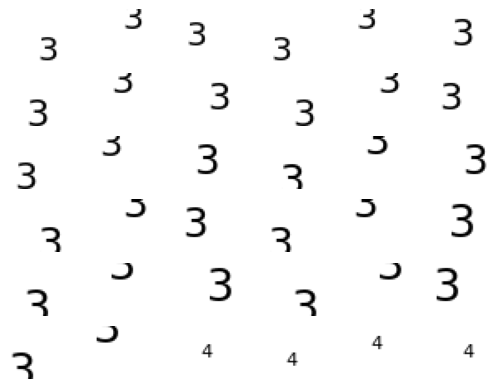

In [54]:
for input_ds, output_ds in dataset.skip(2).take(1):
    for i, el in enumerate(output_ds):  
        ax = plt.subplot(6, 6, i + 1)
        plt.imshow(el[:, :, 0], cmap='gray')
        plt.axis("off")

In [55]:
def make_model(input_shape):
    inputs = keras.layers.Input(shape=input_shape)
    
    x = layers.Dense(64*64, activation="relu")(inputs)
    x = layers.Reshape((64, 64, 1))(x)
    
    x = layers.Conv2D(64, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    
    x = layers.Conv2D(1, 3, strides=1, padding="same")(x)
    x = layers.BatchNormalization()(x)
    outputs = layers.Activation("sigmoid")(x)
    
    return keras.Model(inputs, outputs)

In [56]:
model = make_model(input_shape=(4,))

In [57]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 4)]               0         
                                                                 
 dense_3 (Dense)             (None, 4096)              20480     
                                                                 
 reshape_3 (Reshape)         (None, 64, 64, 1)         0         
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 64)        640       
                                                                 
 batch_normalization_4 (Bat  (None, 32, 32, 64)        256       
 chNormalization)                                                
                                                                 
 activation_4 (Activation)   (None, 32, 32, 64)        0         
                                                           

In [58]:
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="mse"
)

Epoch 1/25
     35/Unknown - 120s 3s/step - loss: 0.0999

2023-08-05 12:46:31.079659: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 15554104351520179931
2023-08-05 12:46:31.079730: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 3284318179959887830


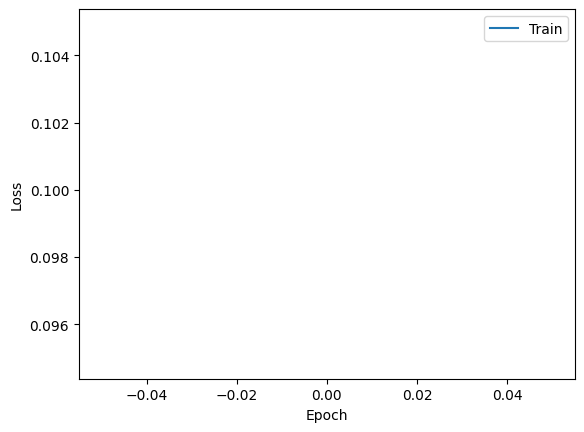

35/35 [==============================] - 121s 3s/step - loss: 0.0999
Epoch 2/25
35/35 [==============================] - ETA: 0s - loss: 0.0977

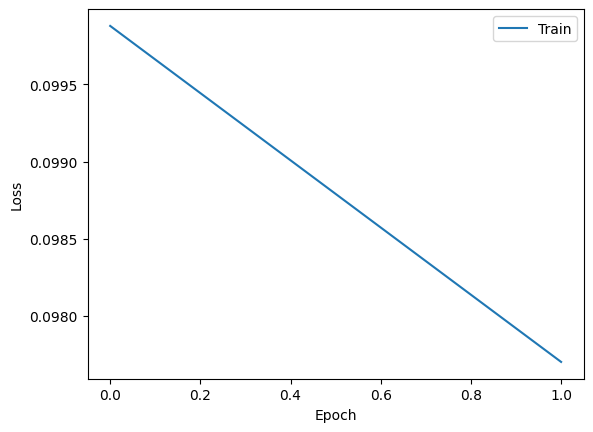

35/35 [==============================] - 117s 3s/step - loss: 0.0977
Epoch 3/25
18/35 [==============>...............] - ETA: 57s - loss: 0.0968 

KeyboardInterrupt: 

In [72]:
from keras.callbacks import Callback


class PlotLosses(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.fig = plt.figure()
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.losses.append(logs.get('loss'))
        
        plt.plot(np.arange(len(self.losses)), self.losses, label='train loss')
        plt.legend(['Train', 'Validation'], loc='upper right')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.draw()
        plt.pause(0.001)

plot_losses = PlotLosses()


history = model.fit(
    dataset,
    epochs=25,
    callbacks=[plot_losses]
)

In [136]:
!nvidia-smi

Sat Aug  5 14:27:28 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:06:00.0 Off |                  N/A |
|  0%   56C    P2    38W / 170W |   1505MiB / 12288MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [70]:
def execute(char: str):
    processed_text = np.concatenate([np.array(preprocess(char)) / float(len(char_to_int) + 1), np.random.rand(3)])
    processed_text = np.array(processed_text)[np.newaxis, :]
    prediction = model.predict(processed_text)
    restored_prediction = prediction * 255
    # plt.figure(figsize=(5,5))
    print(char)
    plt.imshow(restored_prediction[0, :, :, 0], cmap='gray')
    plt.axis('off')
    plt.show()

    return restored_prediction

1/1 [==============================] - 0s 36ms/step
0


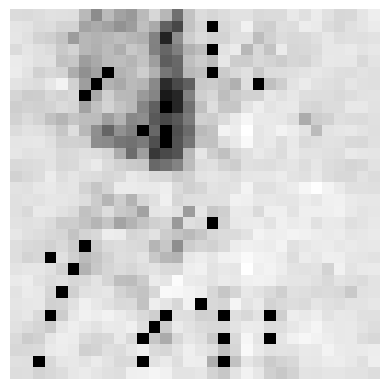

1/1 [==============================] - 0s 29ms/step
1


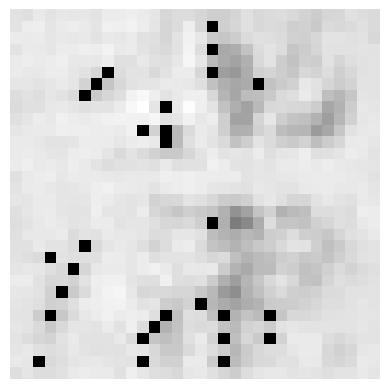

1/1 [==============================] - 0s 28ms/step
2


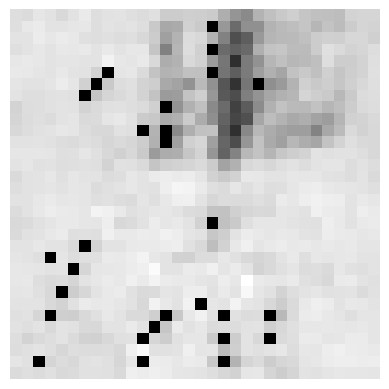

1/1 [==============================] - 0s 26ms/step
3


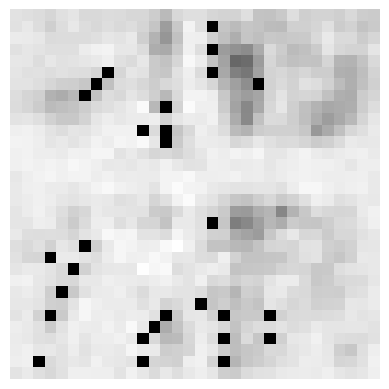

1/1 [==============================] - 0s 23ms/step
4


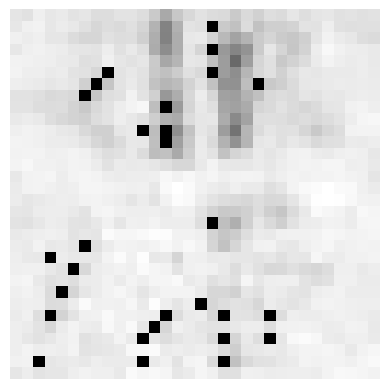

1/1 [==============================] - 0s 23ms/step
5


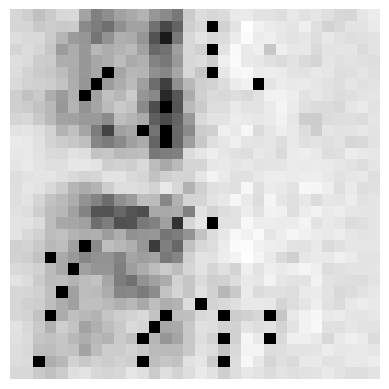

1/1 [==============================] - 0s 37ms/step
6


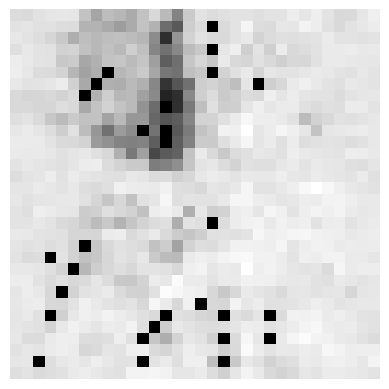

1/1 [==============================] - 0s 29ms/step
7


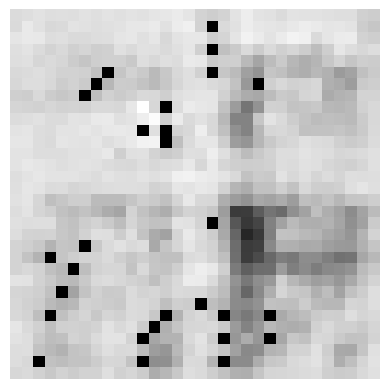

1/1 [==============================] - 0s 25ms/step
8


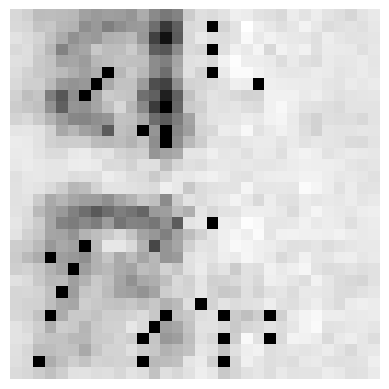

1/1 [==============================] - 0s 24ms/step
9


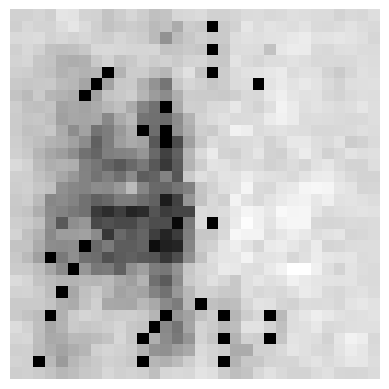

1/1 [==============================] - 0s 25ms/step
A


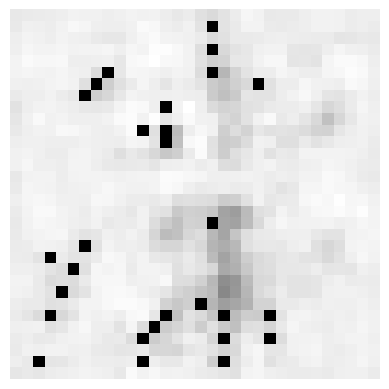

1/1 [==============================] - 0s 31ms/step
B


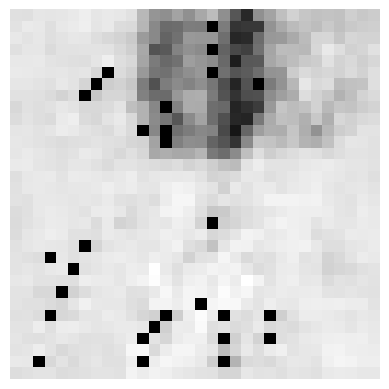

1/1 [==============================] - 0s 25ms/step
C


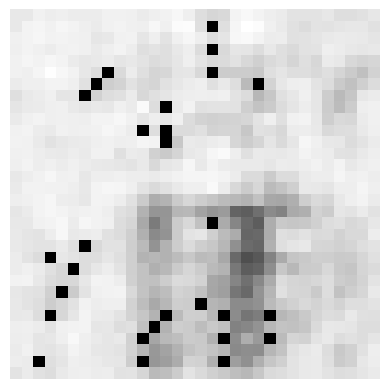

1/1 [==============================] - 0s 25ms/step
D


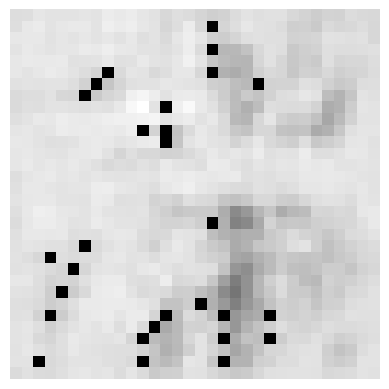

1/1 [==============================] - 0s 25ms/step
E


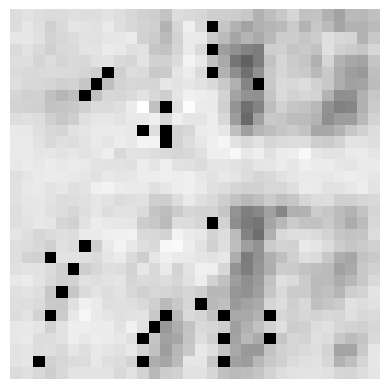

1/1 [==============================] - 0s 26ms/step
F


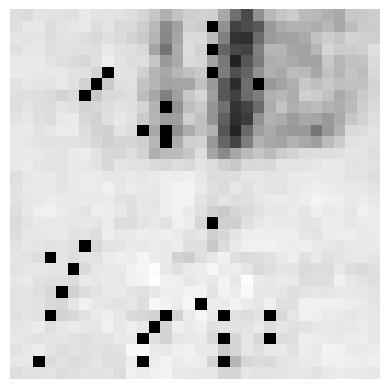

1/1 [==============================] - 0s 26ms/step
G


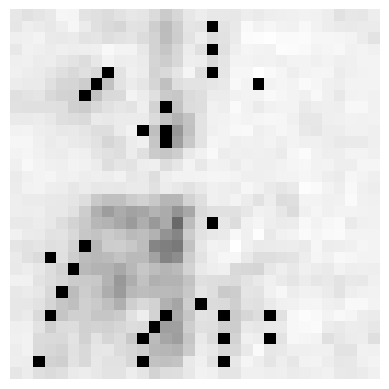

1/1 [==============================] - 0s 26ms/step
H


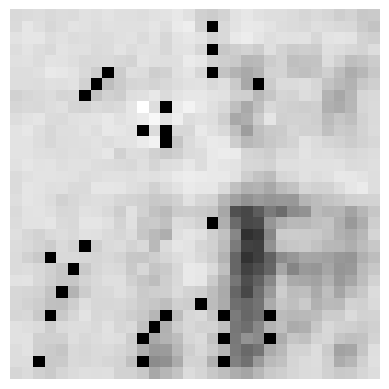

1/1 [==============================] - 0s 24ms/step
I


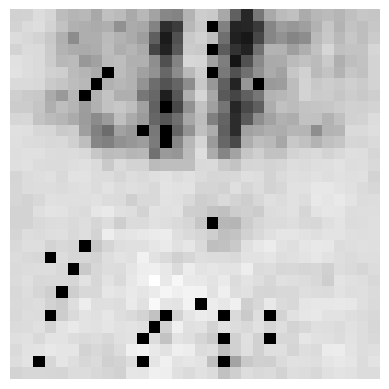

1/1 [==============================] - 0s 23ms/step
J


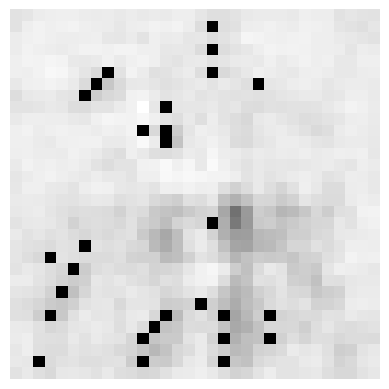

1/1 [==============================] - 0s 23ms/step
K


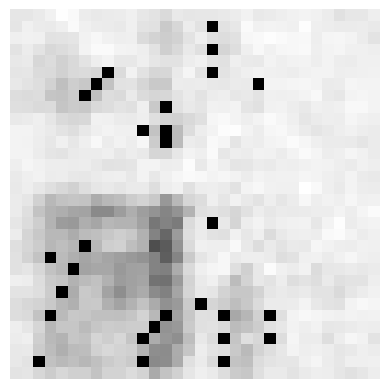

1/1 [==============================] - 0s 27ms/step
L


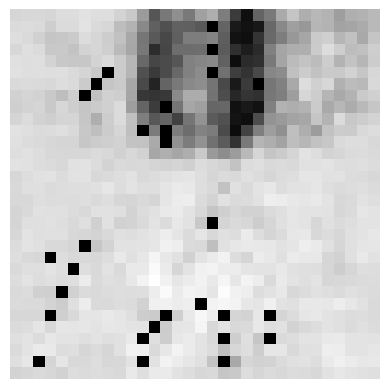

1/1 [==============================] - 0s 25ms/step
M


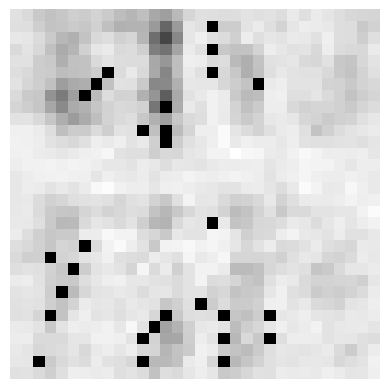

1/1 [==============================] - 0s 22ms/step
N


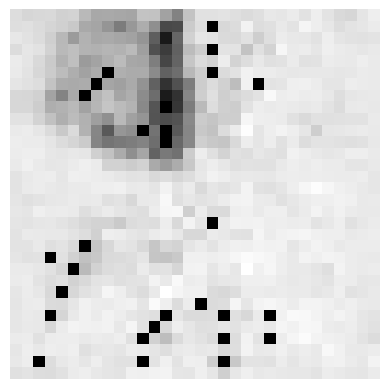

1/1 [==============================] - 0s 25ms/step
O


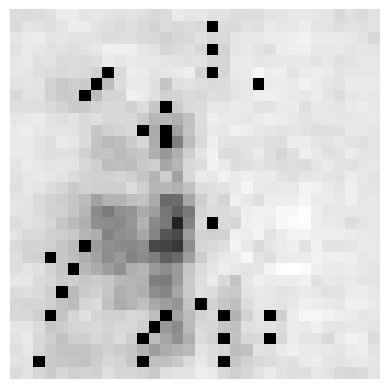

1/1 [==============================] - 0s 21ms/step
P


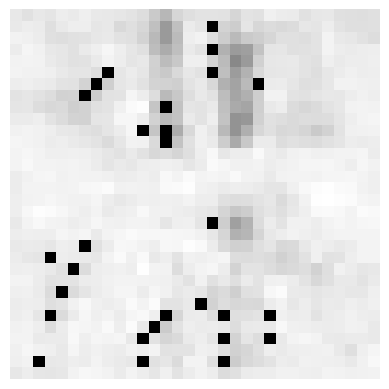

1/1 [==============================] - 0s 22ms/step
Q


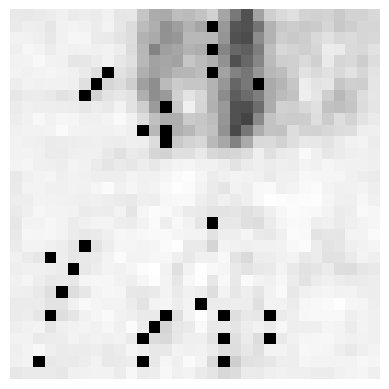

1/1 [==============================] - 0s 21ms/step
R


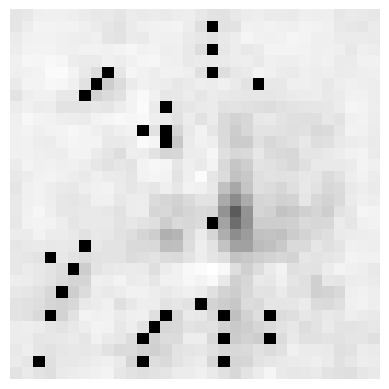

1/1 [==============================] - 0s 22ms/step
S


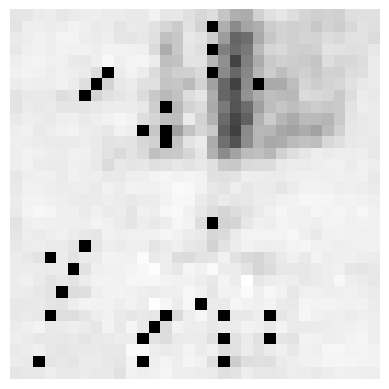

1/1 [==============================] - 0s 21ms/step
T


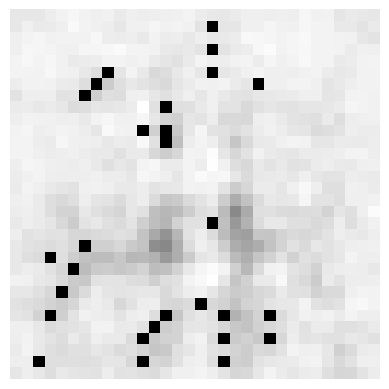

1/1 [==============================] - 0s 25ms/step
U


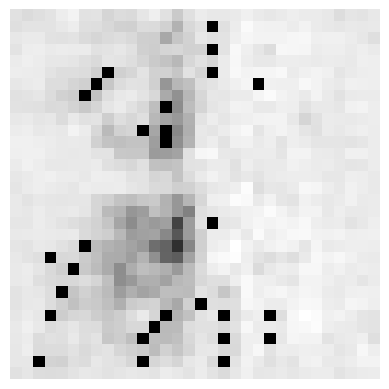

1/1 [==============================] - 0s 27ms/step
V


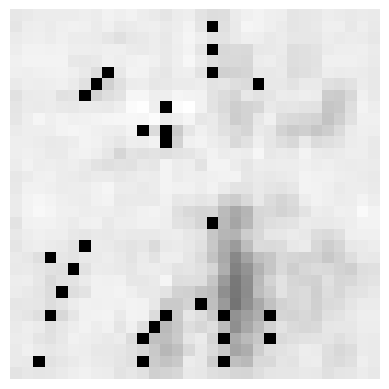

1/1 [==============================] - 0s 26ms/step
W


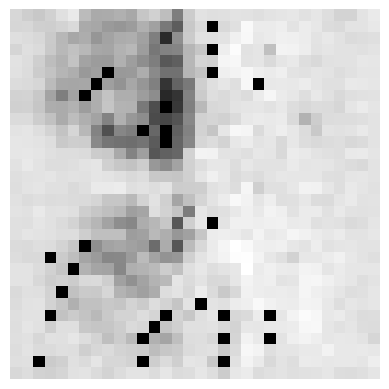

1/1 [==============================] - 0s 21ms/step
X


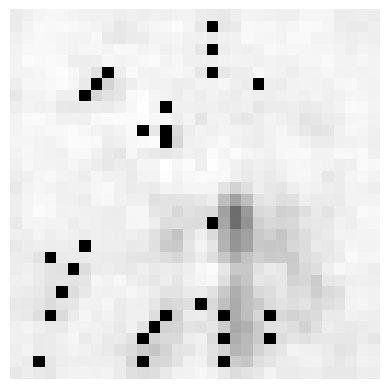

1/1 [==============================] - 0s 31ms/step
Y


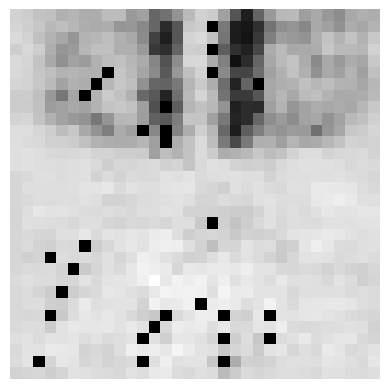

1/1 [==============================] - 0s 22ms/step
Z


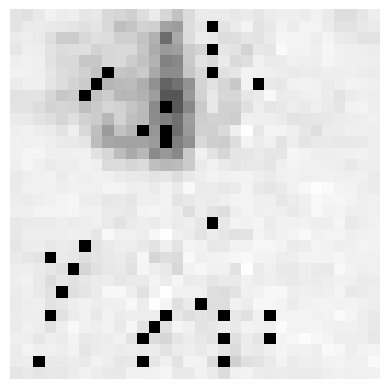

1/1 [==============================] - 0s 25ms/step
a


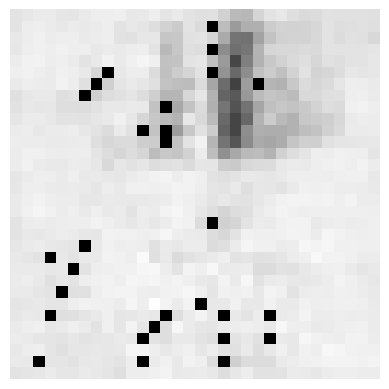

1/1 [==============================] - 0s 116ms/step
b


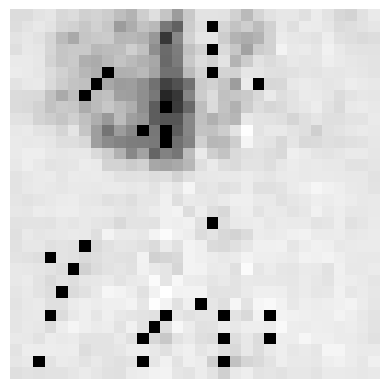

1/1 [==============================] - 0s 32ms/step
c


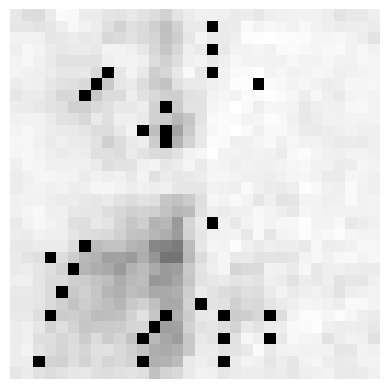

1/1 [==============================] - 0s 26ms/step
d


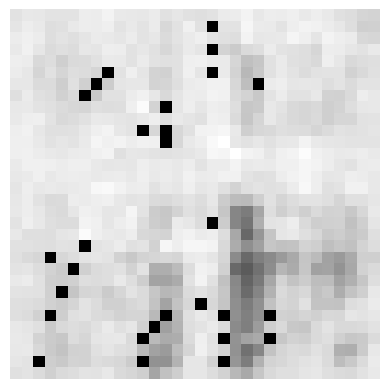

1/1 [==============================] - 0s 43ms/step
e


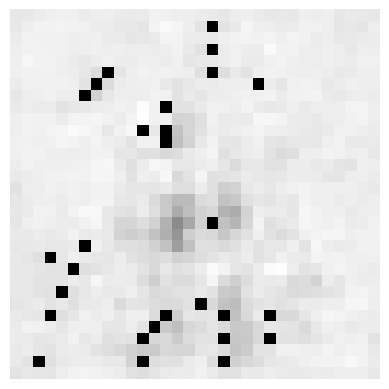

1/1 [==============================] - 0s 23ms/step
f


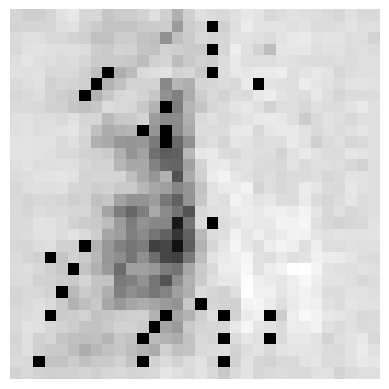

1/1 [==============================] - 0s 49ms/step
g


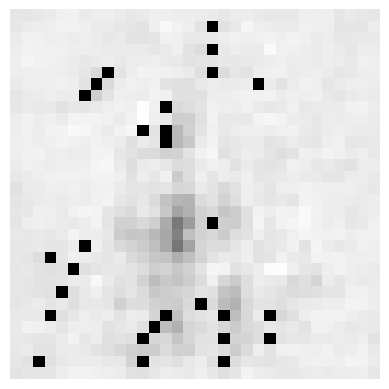

1/1 [==============================] - 0s 26ms/step
h


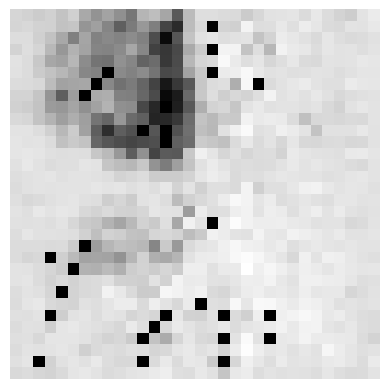

1/1 [==============================] - 0s 26ms/step
i


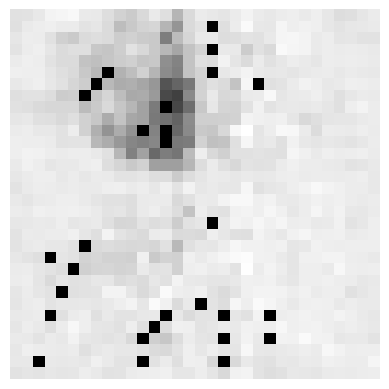

1/1 [==============================] - 0s 25ms/step
j


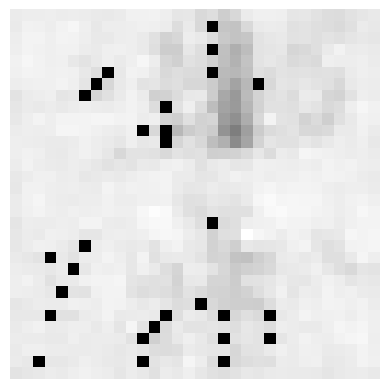

1/1 [==============================] - 0s 25ms/step
k


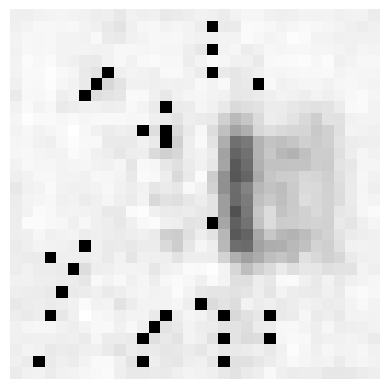

1/1 [==============================] - 0s 26ms/step
l


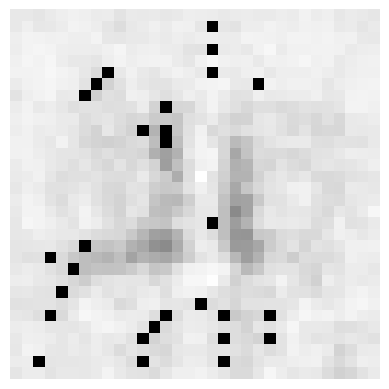

1/1 [==============================] - 0s 22ms/step
m


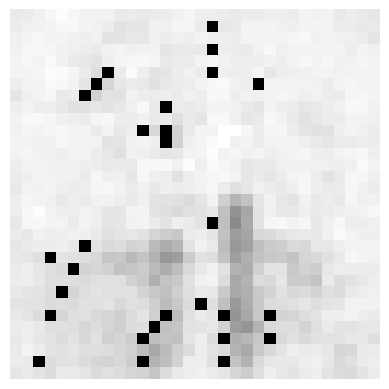

1/1 [==============================] - 0s 27ms/step
n


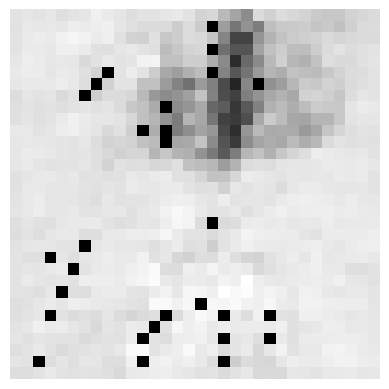

1/1 [==============================] - 0s 23ms/step
o


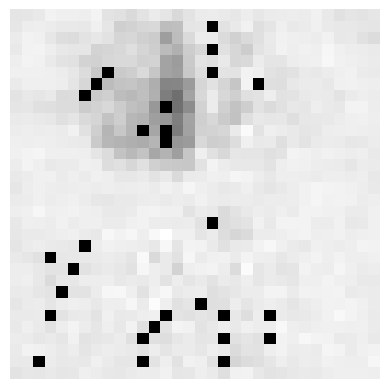

1/1 [==============================] - 0s 30ms/step
p


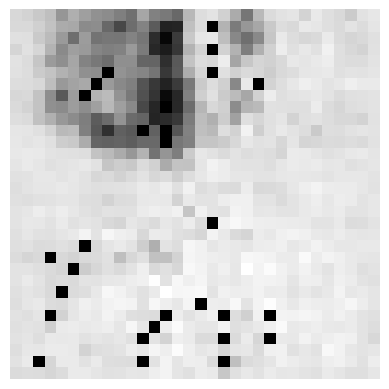

1/1 [==============================] - 0s 25ms/step
q


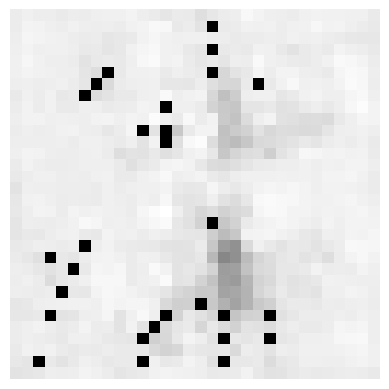

1/1 [==============================] - 0s 25ms/step
r


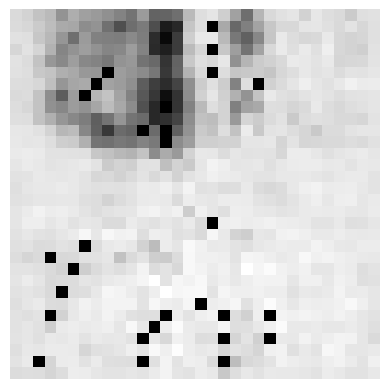

1/1 [==============================] - 0s 22ms/step
s


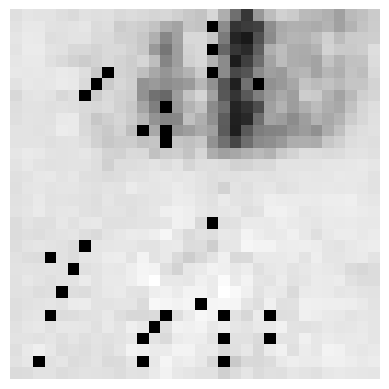

1/1 [==============================] - 0s 26ms/step
t


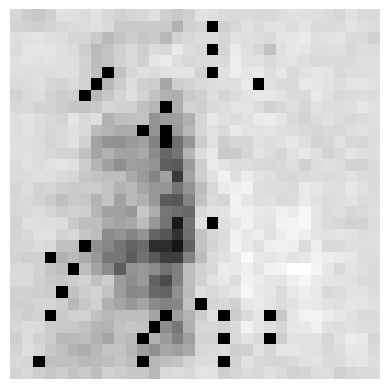

1/1 [==============================] - 0s 27ms/step
u


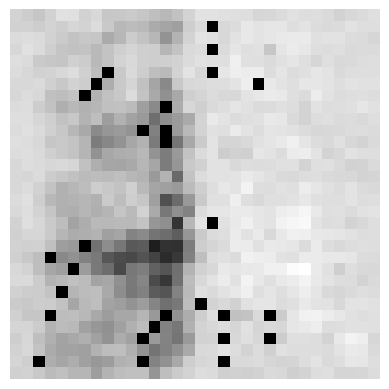

1/1 [==============================] - 0s 23ms/step
v


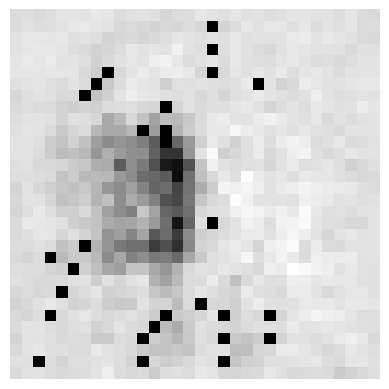

1/1 [==============================] - 0s 25ms/step
w


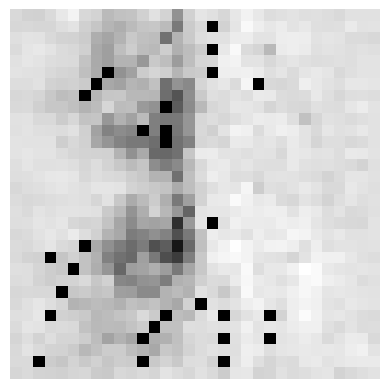

1/1 [==============================] - 0s 22ms/step
x


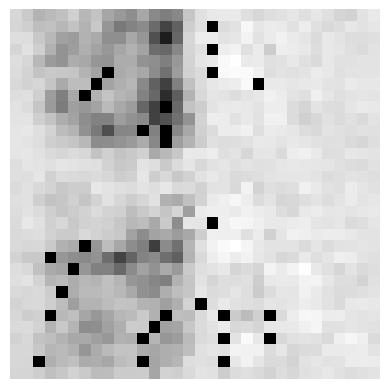

1/1 [==============================] - 0s 21ms/step
y


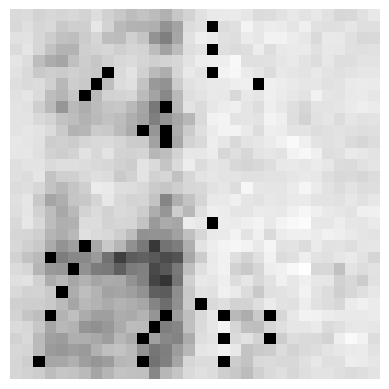

1/1 [==============================] - 0s 26ms/step
z


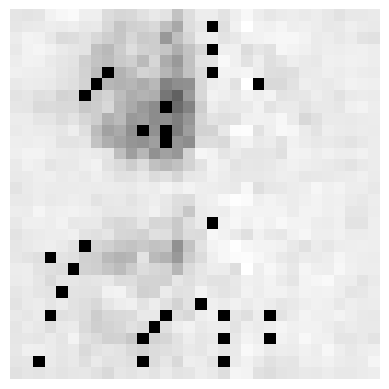

In [71]:
for char in char_to_int.keys():
    execute(char)

tf.Tensor([0. 0. 0. 0.], shape=(4,), dtype=float32)
1/1 [==============================] - 0s 26ms/step


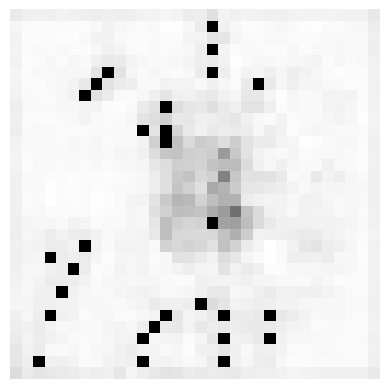

tf.Tensor([0.         0.         0.         0.33333334], shape=(4,), dtype=float32)
1/1 [==============================] - 0s 24ms/step


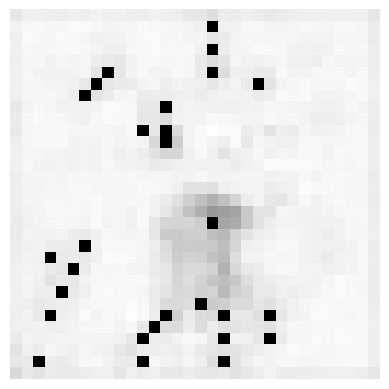

tf.Tensor([0.        0.        0.        0.6666667], shape=(4,), dtype=float32)
1/1 [==============================] - 0s 22ms/step


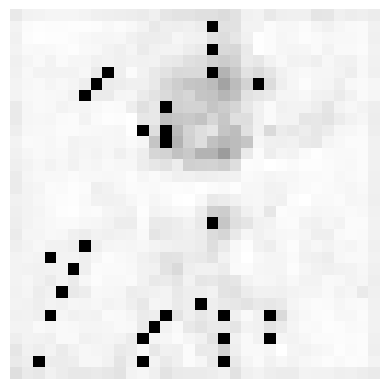

tf.Tensor([0.         0.         0.33333334 0.        ], shape=(4,), dtype=float32)
1/1 [==============================] - 0s 23ms/step


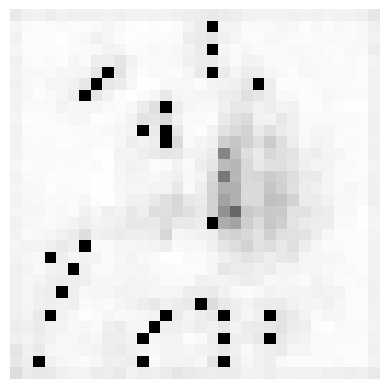

tf.Tensor([0.         0.         0.33333334 0.33333334], shape=(4,), dtype=float32)
1/1 [==============================] - 0s 23ms/step


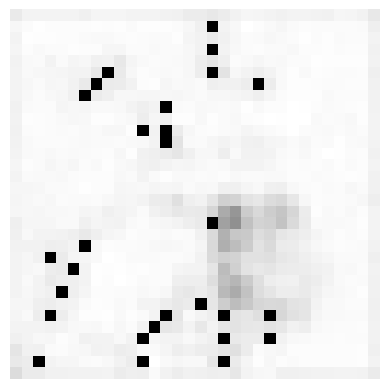

tf.Tensor([0.         0.         0.33333334 0.6666667 ], shape=(4,), dtype=float32)
1/1 [==============================] - 0s 52ms/step


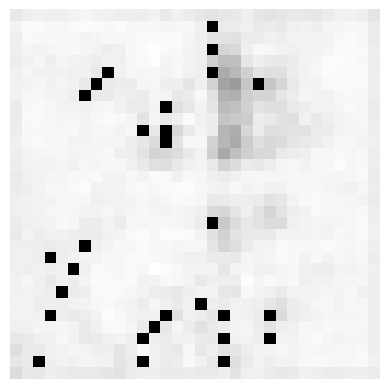

In [79]:
for input_ds, output_ds in dataset.take(1):
    for i, el in enumerate(input_ds):
        if i > 5: break
        print(el)
        plt.imshow(model.predict(el[np.newaxis, :])[0], cmap='gray')
        plt.axis("off")
        plt.show()

In [141]:
class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return mean + tf.math.exp(0.5*log_var) * tf.random.normal(shape=(tf.shape(mean)[0], tf.shape(mean)[1]))


def make_encoder(input_shape, latent_dim, units: list = [64, 32]):
    inputs = keras.layers.Input(shape=input_shape)
    
    x = inputs
    for n_units in units:
        x = layers.Dense(n_units, activation="relu")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation("relu")(x)
    
    mean = layers.Dense(latent_dim)(x)
    log_var = layers.Dense(latent_dim)(x)
    
    z = Sampling()([mean, log_var])
    
    encoder = keras.Model(inputs, [z, mean, log_var], name="encoder")
    return encoder
    

def make_decoder(latent_dim):
    inputs = layers.Input(shape=latent_dim)
    
    x = layers.Dense(8*8*64, activation="relu")(inputs)
    x = layers.Reshape((8, 8, 64))(x)
    
    x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
    
    decoder_output = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
    return keras.Model(inputs, decoder_output, name="decoder")


def make_vae(input_shape, latent_dim, encoder_units):
    encoder = make_encoder(input_shape, latent_dim, encoder_units)
    decoder = make_decoder(latent_dim)
    
    inputs = layers.Input(shape=input_shape)
    z, _, _ = encoder(inputs)
    output = decoder(z)
    return keras.Model(inputs, output, name="vae")

    
def loss_func(y_true, y_pred, mean, log_var):
    loss_reconstruction = tf.reduce_mean(tf.reduce_sum(tf.keras.losses.binary_crossentropy(y_true, y_pred), axis=(1, 2)))
    loss_kl = -0.5 * (1 + log_var - tf.square(mean) - tf.exp(log_var))
    return loss_reconstruction + tf.reduce_mean(tf.reduce_sum(loss_kl, axis=1))
    
    
@tf.function
def training_block(batch, vae, epochs, optimizer):
    encoder = vae.layers[1]
    decoder = vae.layers[2]
    with tf.GradientTape() as recorder:
        x_train, y_train = batch
        z, mean, log_var = encoder(x_train)
        y_pred = decoder(z)
        loss = loss_func(y_train, y_pred, mean, log_var)
        
    partial_derivatives = recorder.gradient(loss, vae.trainable_weights)
    optimizer.apply_gradients(zip(partial_derivatives, vae.trainable_weights))
    return loss


from tqdm import tqdm
optimizer = keras.optimizers.Adam(learning_rate)


def train(dataset, epochs, vae):
    learning_rate = 1e-3
    for epoch in range(1,epochs+1):
        for step, batch in enumerate(tqdm(dataset)):
            loss = training_block(batch, vae, epochs, optimizer)
        print('Training Loss is: ', loss)
    print('Training Complete')

In [121]:
vae = make_vae(input_shape=(4,), latent_dim=2, encoder_units=[64, 32])
vae.summary()

Model: "vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_34 (InputLayer)       [(None, 4)]               0         
                                                                 
 encoder (Functional)        [(None, 2),               2916      
                              (None, 2),                         
                              (None, 2)]                         
                                                                 
 decoder (Functional)        (None, 32, 32, 1)         67969     
                                                                 
Total params: 70885 (276.89 KB)
Trainable params: 70693 (276.14 KB)
Non-trainable params: 192 (768.00 Byte)
_________________________________________________________________


In [152]:
epochs = 125
learning_rate = 1e-2 

In [155]:
train(dataset, epochs=125, vae=vae)

35it [02:10,  3.72s/it]


Training Loss is:  tf.Tensor(102.31966, shape=(), dtype=float32)


8it [00:33,  4.20s/it]


KeyboardInterrupt: 

tf.Tensor([0.12698413 0.875      0.         0.33333334], shape=(4,), dtype=float32)
1/1 [==============================] - 0s 27ms/step


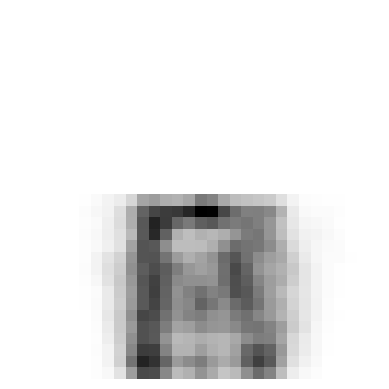

tf.Tensor([0.12698413 0.875      0.         0.6666667 ], shape=(4,), dtype=float32)
1/1 [==============================] - 0s 24ms/step


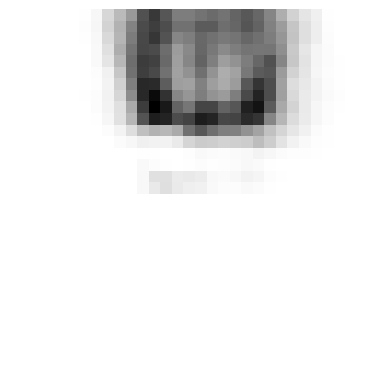

tf.Tensor([0.12698413 0.875      0.33333334 0.        ], shape=(4,), dtype=float32)
1/1 [==============================] - 0s 26ms/step


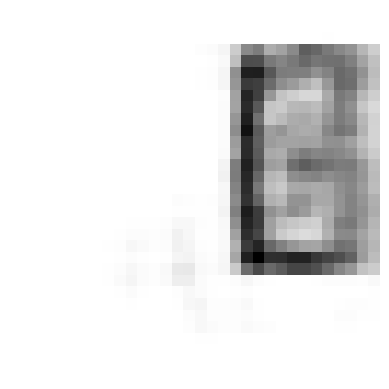

tf.Tensor([0.12698413 0.875      0.33333334 0.33333334], shape=(4,), dtype=float32)
1/1 [==============================] - 0s 25ms/step


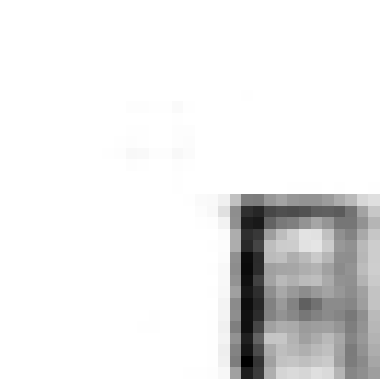

tf.Tensor([0.12698413 0.875      0.33333334 0.6666667 ], shape=(4,), dtype=float32)
1/1 [==============================] - 0s 32ms/step


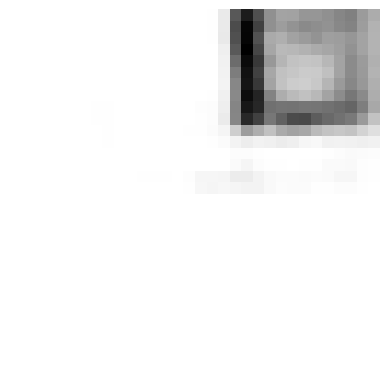

tf.Tensor([0.12698413 0.875      0.6666667  0.        ], shape=(4,), dtype=float32)
1/1 [==============================] - 0s 26ms/step


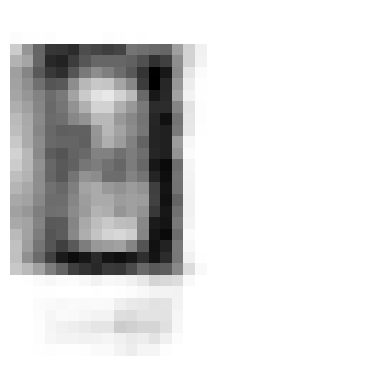

tf.Tensor([0.12698413 0.875      0.6666667  0.33333334], shape=(4,), dtype=float32)
1/1 [==============================] - 0s 35ms/step


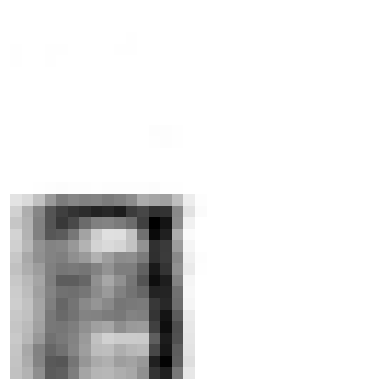

tf.Tensor([0.12698413 0.875      0.6666667  0.6666667 ], shape=(4,), dtype=float32)
1/1 [==============================] - 0s 26ms/step


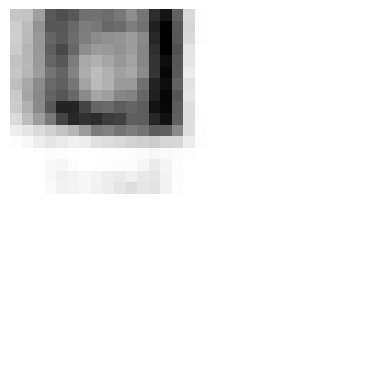

tf.Tensor([0.14285715 0.         0.         0.        ], shape=(4,), dtype=float32)
1/1 [==============================] - 0s 28ms/step


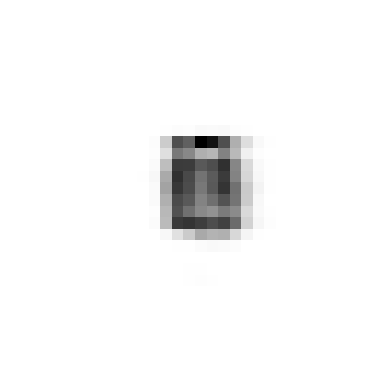

tf.Tensor([0.14285715 0.         0.         0.33333334], shape=(4,), dtype=float32)
1/1 [==============================] - 0s 28ms/step


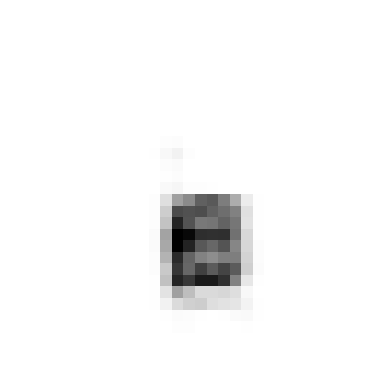

tf.Tensor([0.14285715 0.         0.         0.6666667 ], shape=(4,), dtype=float32)
1/1 [==============================] - 0s 25ms/step


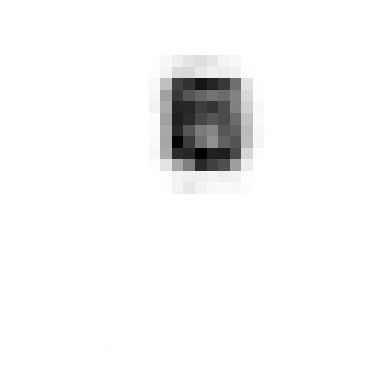

tf.Tensor([0.14285715 0.         0.33333334 0.        ], shape=(4,), dtype=float32)
1/1 [==============================] - 0s 24ms/step


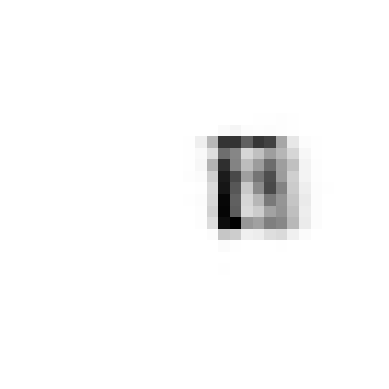

tf.Tensor([0.14285715 0.         0.33333334 0.33333334], shape=(4,), dtype=float32)
1/1 [==============================] - 0s 25ms/step


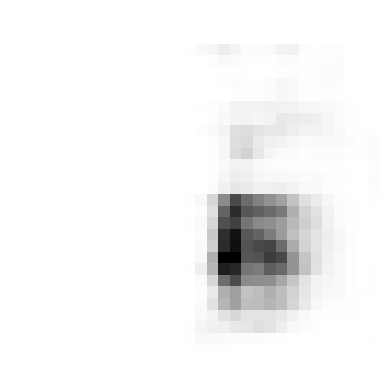

tf.Tensor([0.14285715 0.         0.33333334 0.6666667 ], shape=(4,), dtype=float32)
1/1 [==============================] - 0s 25ms/step


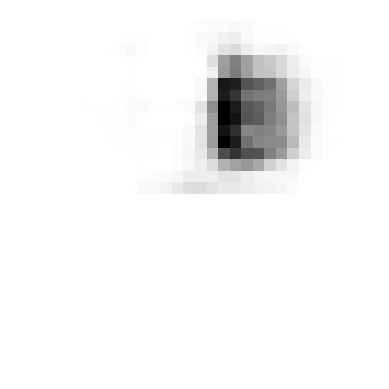

tf.Tensor([0.14285715 0.         0.6666667  0.        ], shape=(4,), dtype=float32)
1/1 [==============================] - 0s 26ms/step


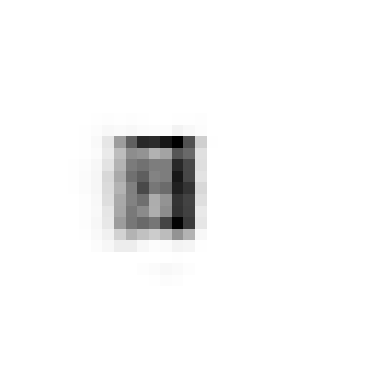

tf.Tensor([0.14285715 0.         0.6666667  0.33333334], shape=(4,), dtype=float32)
1/1 [==============================] - 0s 23ms/step


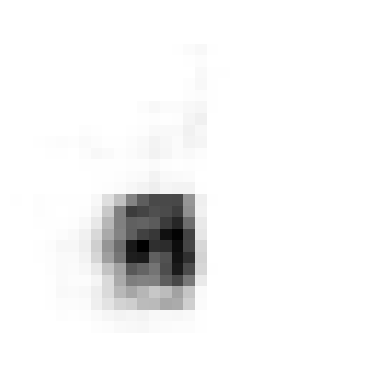

tf.Tensor([0.14285715 0.         0.6666667  0.6666667 ], shape=(4,), dtype=float32)
1/1 [==============================] - 0s 25ms/step


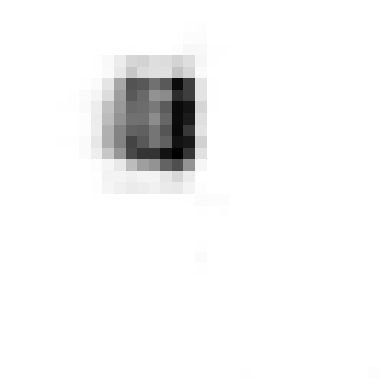

tf.Tensor([0.14285715 0.125      0.         0.        ], shape=(4,), dtype=float32)
1/1 [==============================] - 0s 30ms/step


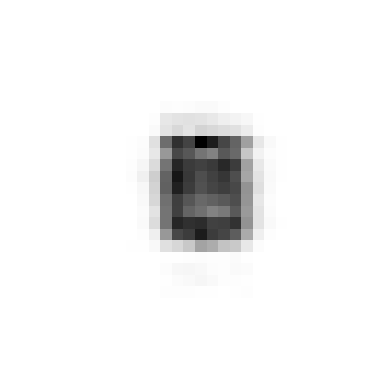

tf.Tensor([0.14285715 0.125      0.         0.33333334], shape=(4,), dtype=float32)
1/1 [==============================] - 0s 25ms/step


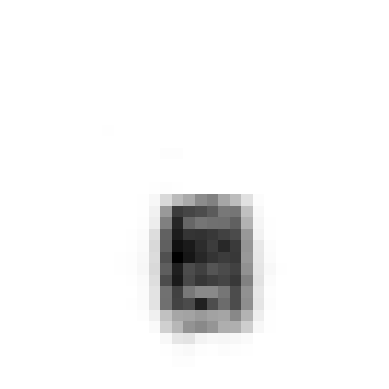

tf.Tensor([0.14285715 0.125      0.         0.6666667 ], shape=(4,), dtype=float32)
1/1 [==============================] - 0s 26ms/step


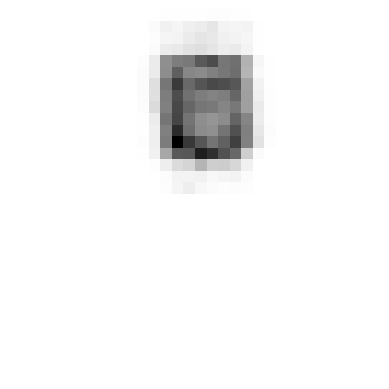

tf.Tensor([0.14285715 0.125      0.33333334 0.        ], shape=(4,), dtype=float32)
1/1 [==============================] - 0s 26ms/step


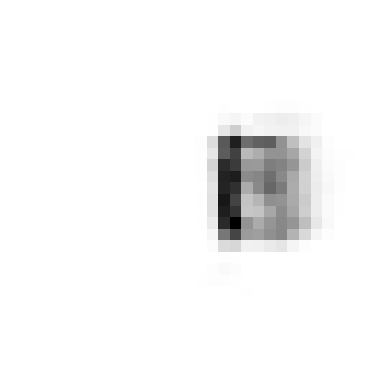

tf.Tensor([0.14285715 0.125      0.33333334 0.33333334], shape=(4,), dtype=float32)
1/1 [==============================] - 0s 50ms/step


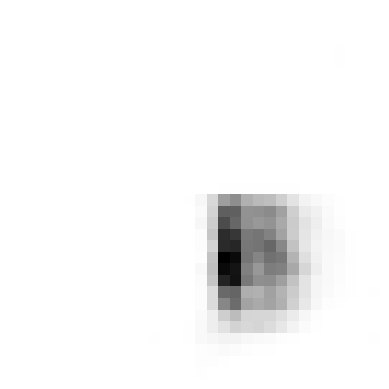

tf.Tensor([0.14285715 0.125      0.33333334 0.6666667 ], shape=(4,), dtype=float32)
1/1 [==============================] - 0s 26ms/step


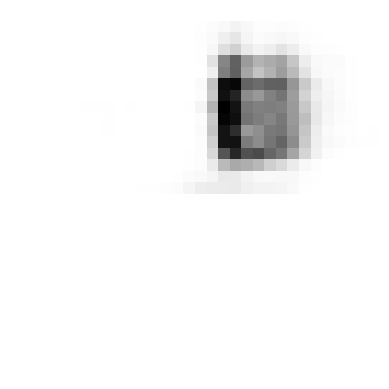

tf.Tensor([0.14285715 0.125      0.6666667  0.        ], shape=(4,), dtype=float32)
1/1 [==============================] - 0s 23ms/step


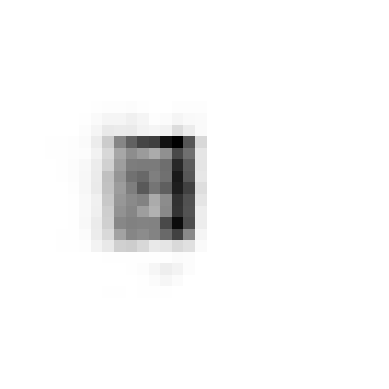

tf.Tensor([0.14285715 0.125      0.6666667  0.33333334], shape=(4,), dtype=float32)
1/1 [==============================] - 0s 27ms/step


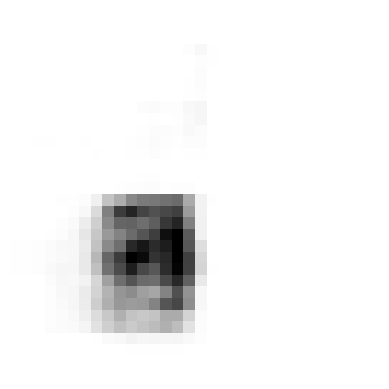

tf.Tensor([0.14285715 0.125      0.6666667  0.6666667 ], shape=(4,), dtype=float32)
1/1 [==============================] - 0s 26ms/step


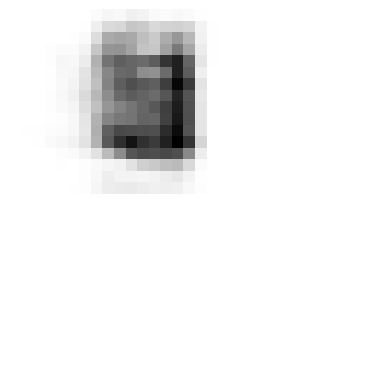

tf.Tensor([0.14285715 0.25       0.         0.        ], shape=(4,), dtype=float32)
1/1 [==============================] - 0s 25ms/step


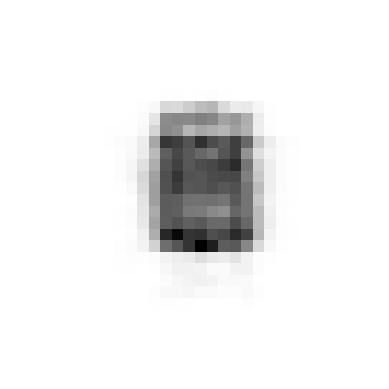

tf.Tensor([0.14285715 0.25       0.         0.33333334], shape=(4,), dtype=float32)
1/1 [==============================] - 0s 25ms/step


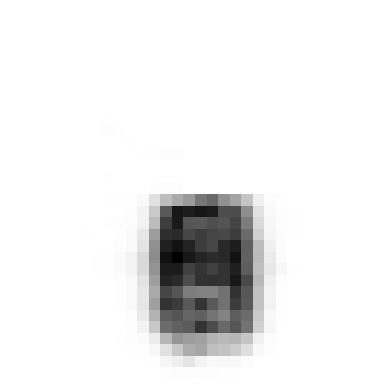

tf.Tensor([0.14285715 0.25       0.         0.6666667 ], shape=(4,), dtype=float32)
1/1 [==============================] - 0s 28ms/step


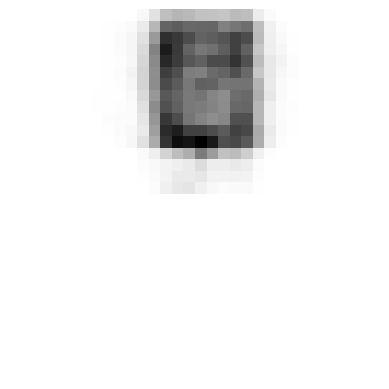

tf.Tensor([0.14285715 0.25       0.33333334 0.        ], shape=(4,), dtype=float32)
1/1 [==============================] - 0s 23ms/step


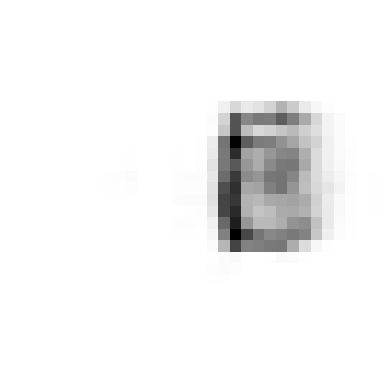

tf.Tensor([0.14285715 0.25       0.33333334 0.33333334], shape=(4,), dtype=float32)
1/1 [==============================] - 0s 26ms/step


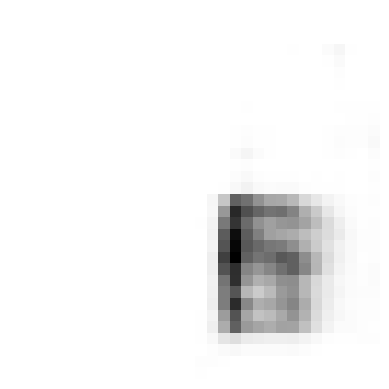

tf.Tensor([0.14285715 0.25       0.33333334 0.6666667 ], shape=(4,), dtype=float32)
1/1 [==============================] - 0s 25ms/step


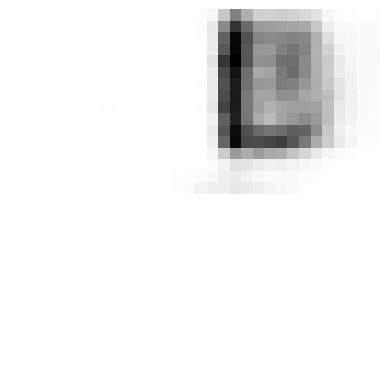

tf.Tensor([0.14285715 0.25       0.6666667  0.        ], shape=(4,), dtype=float32)
1/1 [==============================] - 0s 26ms/step


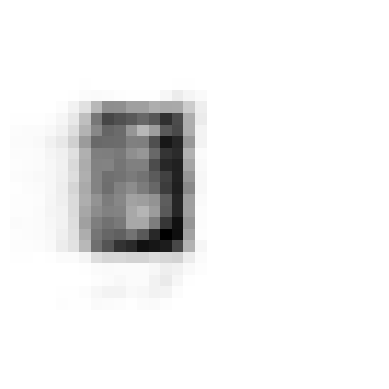

tf.Tensor([0.14285715 0.25       0.6666667  0.33333334], shape=(4,), dtype=float32)
1/1 [==============================] - 0s 25ms/step


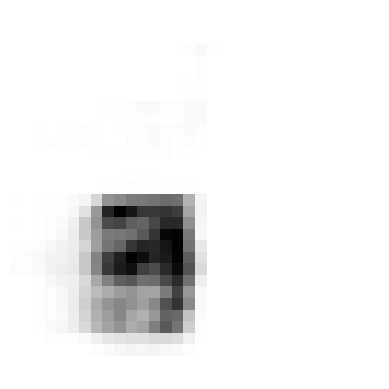

tf.Tensor([0.14285715 0.25       0.6666667  0.6666667 ], shape=(4,), dtype=float32)
1/1 [==============================] - 0s 23ms/step


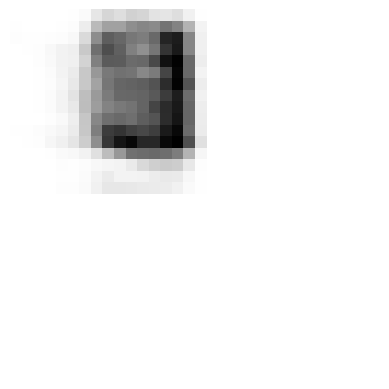

tf.Tensor([0.14285715 0.375      0.         0.        ], shape=(4,), dtype=float32)
1/1 [==============================] - 0s 25ms/step


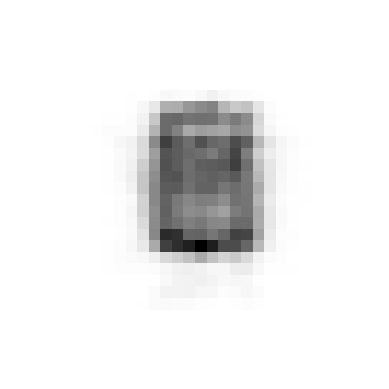

tf.Tensor([0.14285715 0.375      0.         0.33333334], shape=(4,), dtype=float32)
1/1 [==============================] - 0s 25ms/step


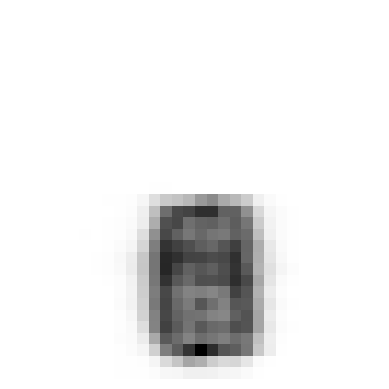

tf.Tensor([0.14285715 0.375      0.         0.6666667 ], shape=(4,), dtype=float32)
1/1 [==============================] - 0s 30ms/step


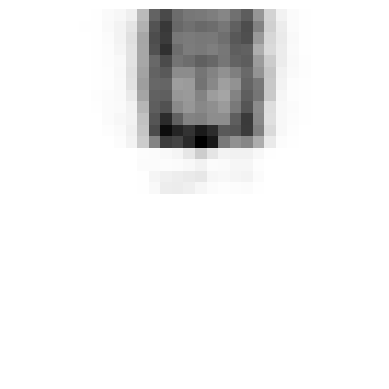

tf.Tensor([0.14285715 0.375      0.33333334 0.        ], shape=(4,), dtype=float32)
1/1 [==============================] - 0s 24ms/step


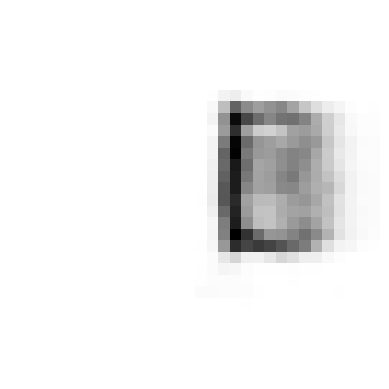

tf.Tensor([0.14285715 0.375      0.33333334 0.33333334], shape=(4,), dtype=float32)
1/1 [==============================] - 0s 27ms/step


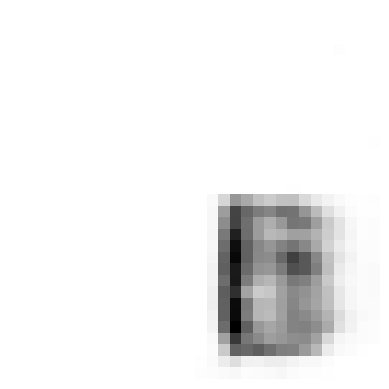

tf.Tensor([0.14285715 0.375      0.33333334 0.6666667 ], shape=(4,), dtype=float32)
1/1 [==============================] - 0s 25ms/step


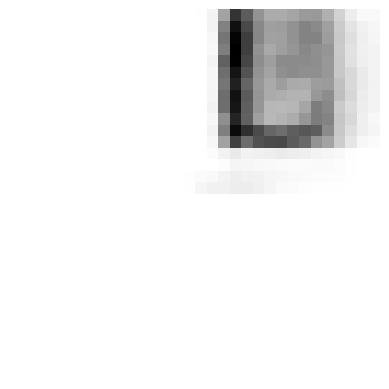

tf.Tensor([0.14285715 0.375      0.6666667  0.        ], shape=(4,), dtype=float32)
1/1 [==============================] - 0s 26ms/step


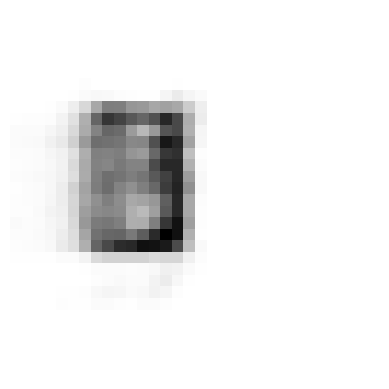

tf.Tensor([0.14285715 0.375      0.6666667  0.33333334], shape=(4,), dtype=float32)
1/1 [==============================] - 0s 27ms/step


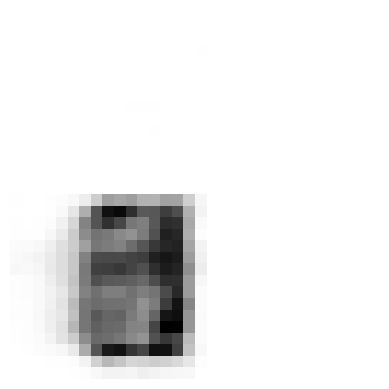

tf.Tensor([0.14285715 0.375      0.6666667  0.6666667 ], shape=(4,), dtype=float32)
1/1 [==============================] - 0s 27ms/step


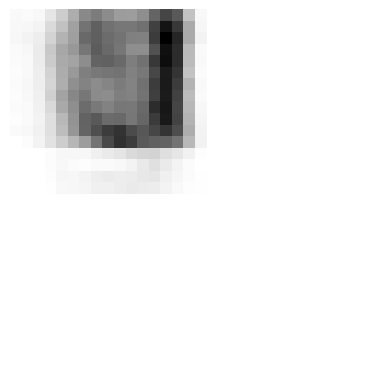

tf.Tensor([0.14285715 0.5        0.         0.        ], shape=(4,), dtype=float32)
1/1 [==============================] - 0s 24ms/step


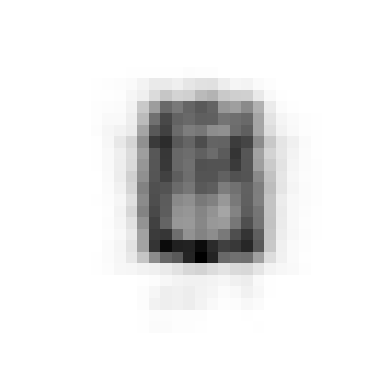

tf.Tensor([0.14285715 0.5        0.         0.33333334], shape=(4,), dtype=float32)
1/1 [==============================] - 0s 51ms/step


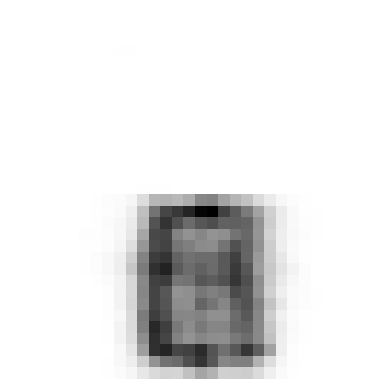

tf.Tensor([0.14285715 0.5        0.         0.6666667 ], shape=(4,), dtype=float32)
1/1 [==============================] - 0s 25ms/step


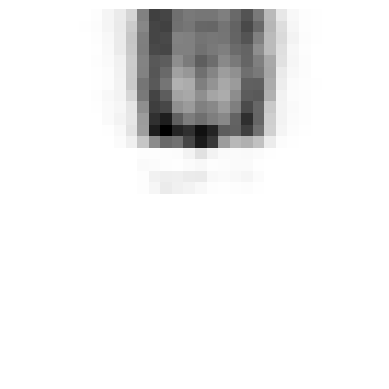

tf.Tensor([0.14285715 0.5        0.33333334 0.        ], shape=(4,), dtype=float32)
1/1 [==============================] - 0s 52ms/step


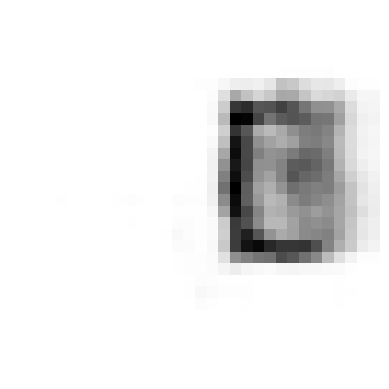

tf.Tensor([0.14285715 0.5        0.33333334 0.33333334], shape=(4,), dtype=float32)
1/1 [==============================] - 0s 26ms/step


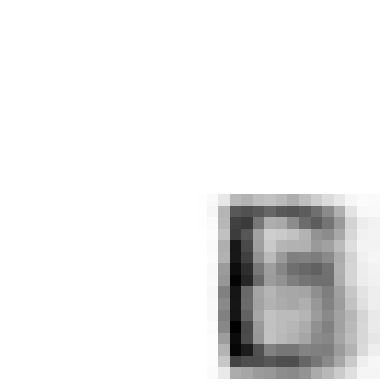

tf.Tensor([0.14285715 0.5        0.33333334 0.6666667 ], shape=(4,), dtype=float32)
1/1 [==============================] - 0s 24ms/step


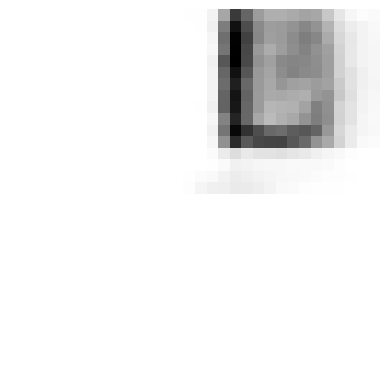

tf.Tensor([0.14285715 0.5        0.6666667  0.        ], shape=(4,), dtype=float32)
1/1 [==============================] - 0s 25ms/step


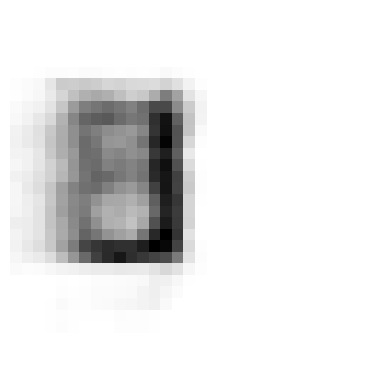

tf.Tensor([0.14285715 0.5        0.6666667  0.33333334], shape=(4,), dtype=float32)
1/1 [==============================] - 0s 22ms/step


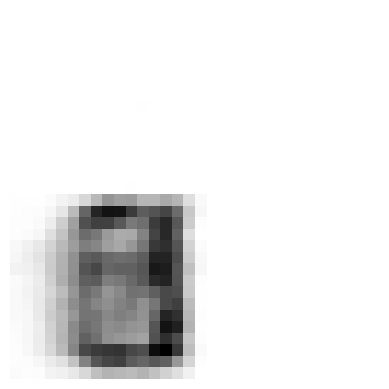

tf.Tensor([0.14285715 0.5        0.6666667  0.6666667 ], shape=(4,), dtype=float32)
1/1 [==============================] - 0s 22ms/step


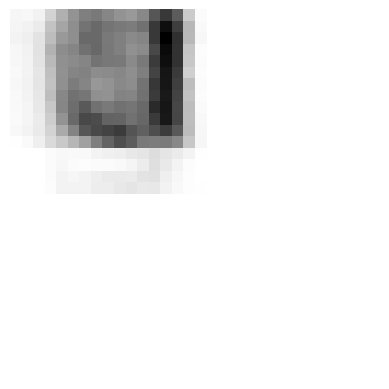

tf.Tensor([0.14285715 0.625      0.         0.        ], shape=(4,), dtype=float32)
1/1 [==============================] - 0s 25ms/step


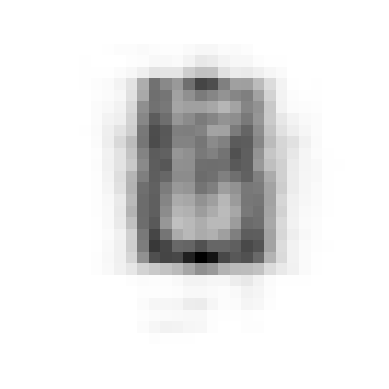

tf.Tensor([0.14285715 0.625      0.         0.33333334], shape=(4,), dtype=float32)
1/1 [==============================] - 0s 23ms/step


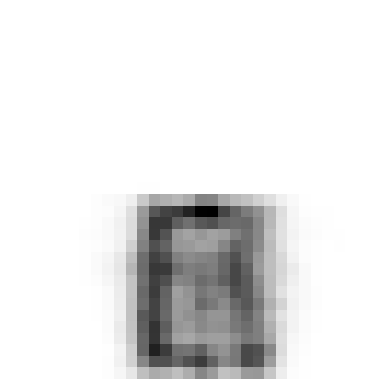

tf.Tensor([0.14285715 0.625      0.         0.6666667 ], shape=(4,), dtype=float32)
1/1 [==============================] - 0s 22ms/step


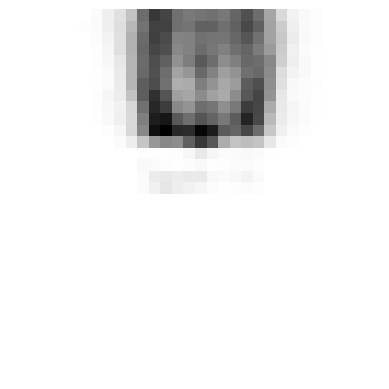

tf.Tensor([0.14285715 0.625      0.33333334 0.        ], shape=(4,), dtype=float32)
1/1 [==============================] - 0s 23ms/step


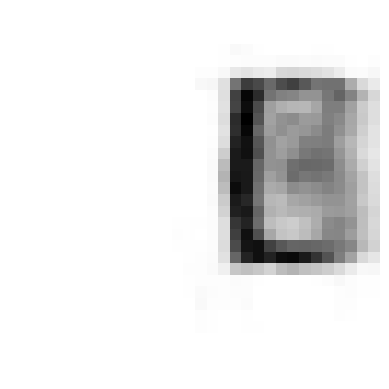

tf.Tensor([0.14285715 0.625      0.33333334 0.33333334], shape=(4,), dtype=float32)
1/1 [==============================] - 0s 25ms/step


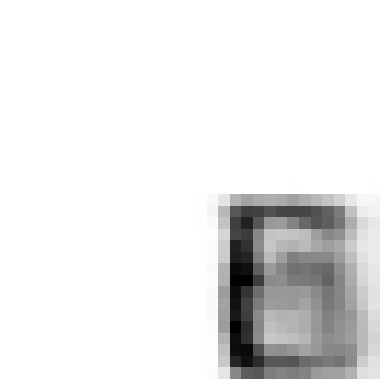

tf.Tensor([0.14285715 0.625      0.33333334 0.6666667 ], shape=(4,), dtype=float32)
1/1 [==============================] - 0s 26ms/step


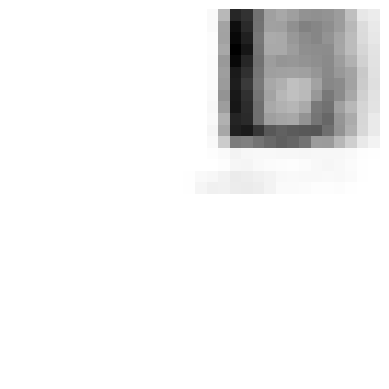

tf.Tensor([0.14285715 0.625      0.6666667  0.        ], shape=(4,), dtype=float32)
1/1 [==============================] - 0s 26ms/step


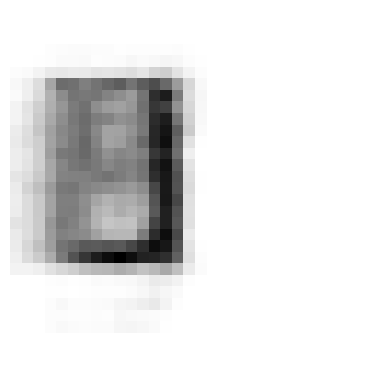

tf.Tensor([0.14285715 0.625      0.6666667  0.33333334], shape=(4,), dtype=float32)
1/1 [==============================] - 0s 23ms/step


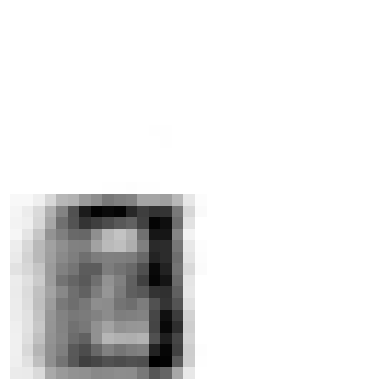

tf.Tensor([0.14285715 0.625      0.6666667  0.6666667 ], shape=(4,), dtype=float32)
1/1 [==============================] - 0s 24ms/step


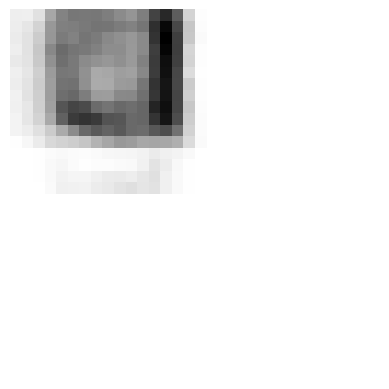

tf.Tensor([0.14285715 0.75       0.         0.        ], shape=(4,), dtype=float32)
1/1 [==============================] - 0s 23ms/step


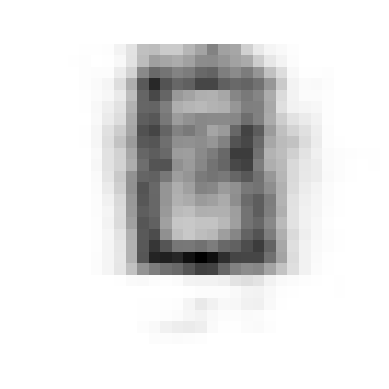

tf.Tensor([0.14285715 0.75       0.         0.33333334], shape=(4,), dtype=float32)
1/1 [==============================] - 0s 23ms/step


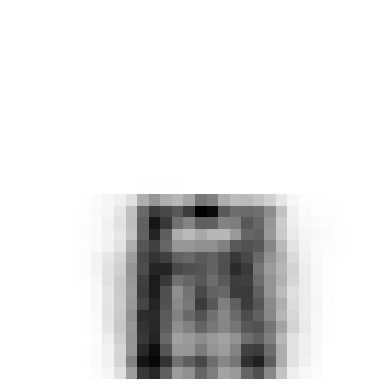

tf.Tensor([0.14285715 0.75       0.         0.6666667 ], shape=(4,), dtype=float32)
1/1 [==============================] - 0s 23ms/step


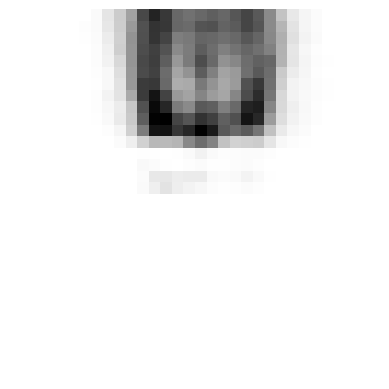

tf.Tensor([0.14285715 0.75       0.33333334 0.        ], shape=(4,), dtype=float32)
1/1 [==============================] - 0s 23ms/step


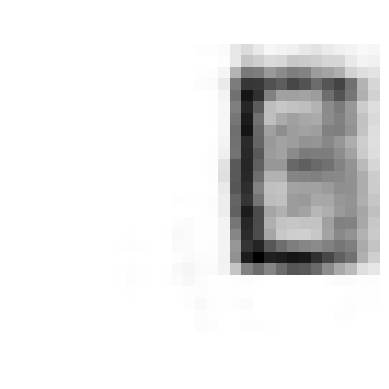

tf.Tensor([0.14285715 0.75       0.33333334 0.33333334], shape=(4,), dtype=float32)
1/1 [==============================] - 0s 25ms/step


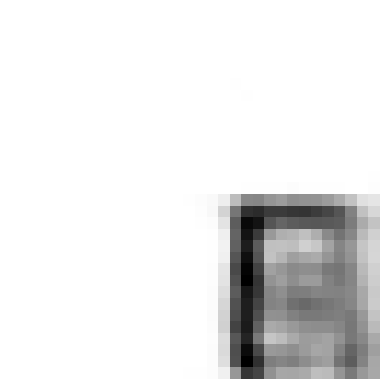

tf.Tensor([0.14285715 0.75       0.33333334 0.6666667 ], shape=(4,), dtype=float32)
1/1 [==============================] - 0s 26ms/step


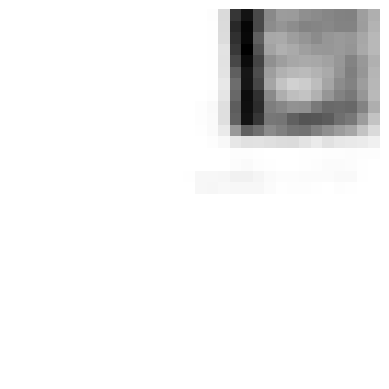

tf.Tensor([0.14285715 0.75       0.6666667  0.        ], shape=(4,), dtype=float32)
1/1 [==============================] - 0s 24ms/step


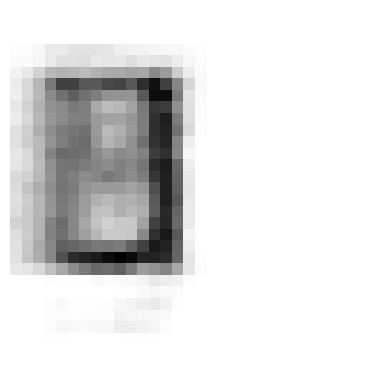

tf.Tensor([0.14285715 0.75       0.6666667  0.33333334], shape=(4,), dtype=float32)
1/1 [==============================] - 0s 23ms/step


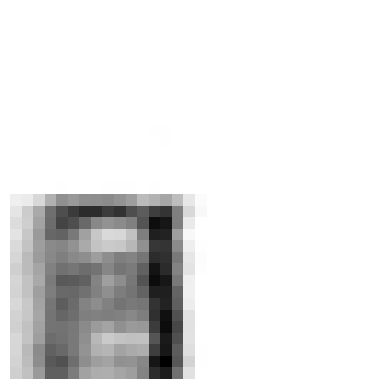

tf.Tensor([0.14285715 0.75       0.6666667  0.6666667 ], shape=(4,), dtype=float32)
1/1 [==============================] - 0s 27ms/step


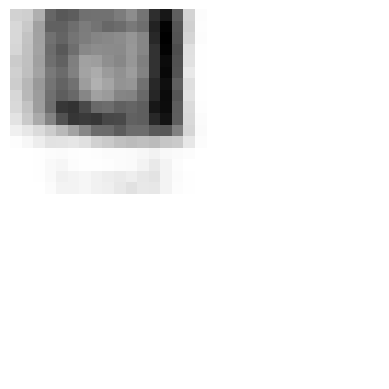

tf.Tensor([0.14285715 0.875      0.         0.        ], shape=(4,), dtype=float32)
1/1 [==============================] - 0s 25ms/step


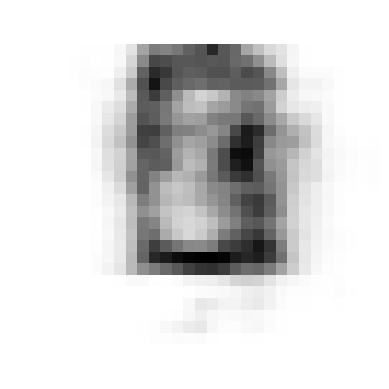

tf.Tensor([0.14285715 0.875      0.         0.33333334], shape=(4,), dtype=float32)
1/1 [==============================] - 0s 26ms/step


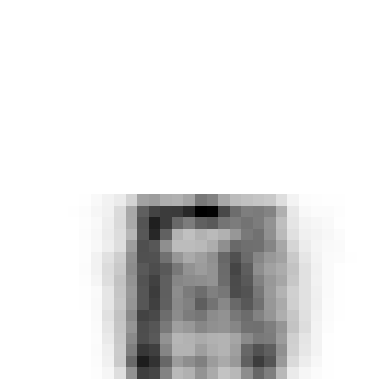

tf.Tensor([0.14285715 0.875      0.         0.6666667 ], shape=(4,), dtype=float32)
1/1 [==============================] - 0s 23ms/step


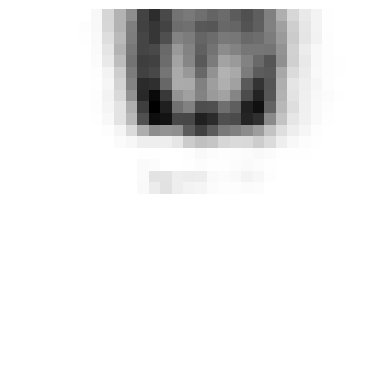

tf.Tensor([0.14285715 0.875      0.33333334 0.        ], shape=(4,), dtype=float32)
1/1 [==============================] - 0s 33ms/step


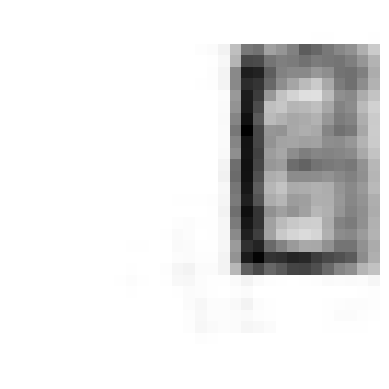

tf.Tensor([0.14285715 0.875      0.33333334 0.33333334], shape=(4,), dtype=float32)
1/1 [==============================] - 0s 23ms/step


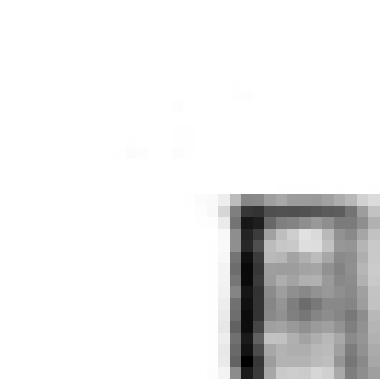

tf.Tensor([0.14285715 0.875      0.33333334 0.6666667 ], shape=(4,), dtype=float32)
1/1 [==============================] - 0s 25ms/step


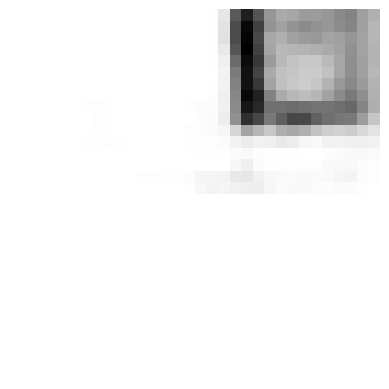

tf.Tensor([0.14285715 0.875      0.6666667  0.        ], shape=(4,), dtype=float32)
1/1 [==============================] - 0s 23ms/step


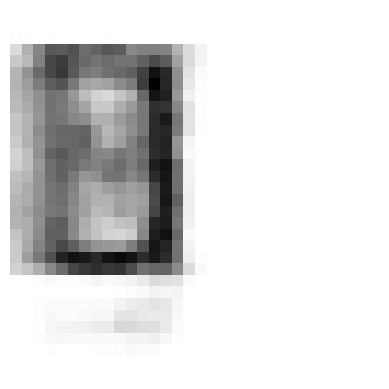

tf.Tensor([0.14285715 0.875      0.6666667  0.33333334], shape=(4,), dtype=float32)
1/1 [==============================] - 0s 23ms/step


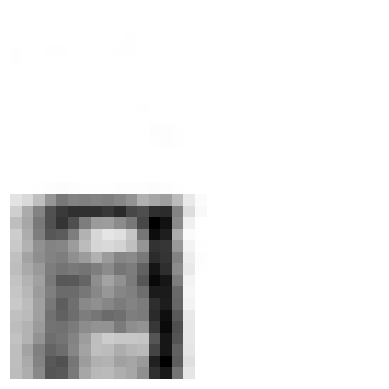

tf.Tensor([0.14285715 0.875      0.6666667  0.6666667 ], shape=(4,), dtype=float32)
1/1 [==============================] - 0s 26ms/step


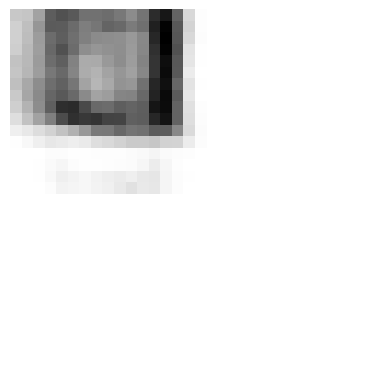

tf.Tensor([0.15873016 0.         0.         0.        ], shape=(4,), dtype=float32)
1/1 [==============================] - 0s 22ms/step


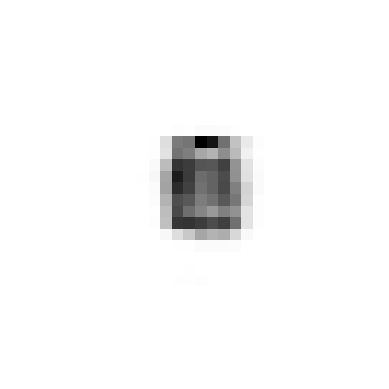

tf.Tensor([0.15873016 0.         0.         0.33333334], shape=(4,), dtype=float32)
1/1 [==============================] - 0s 26ms/step


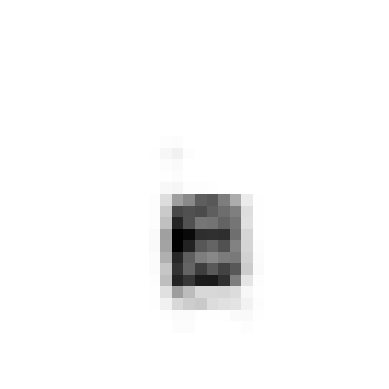

tf.Tensor([0.15873016 0.         0.         0.6666667 ], shape=(4,), dtype=float32)
1/1 [==============================] - 0s 23ms/step


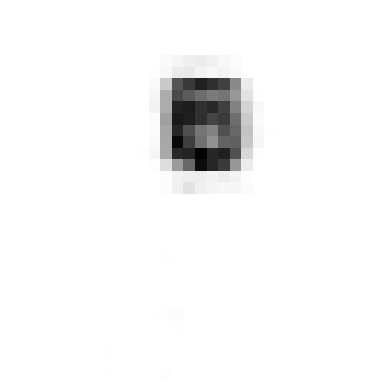

tf.Tensor([0.15873016 0.         0.33333334 0.        ], shape=(4,), dtype=float32)
1/1 [==============================] - 0s 23ms/step


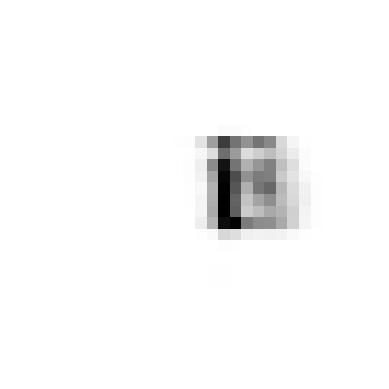

tf.Tensor([0.15873016 0.         0.33333334 0.33333334], shape=(4,), dtype=float32)
1/1 [==============================] - 0s 52ms/step


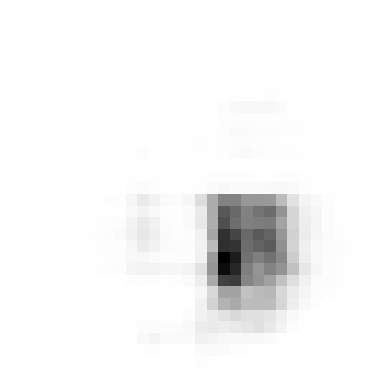

tf.Tensor([0.15873016 0.         0.33333334 0.6666667 ], shape=(4,), dtype=float32)
1/1 [==============================] - 0s 26ms/step


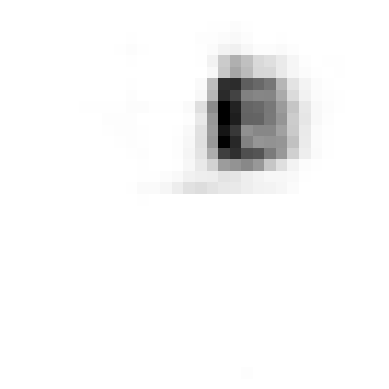

tf.Tensor([0.15873016 0.         0.6666667  0.        ], shape=(4,), dtype=float32)
1/1 [==============================] - 0s 24ms/step


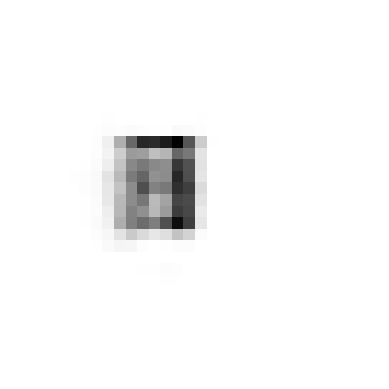

tf.Tensor([0.15873016 0.         0.6666667  0.33333334], shape=(4,), dtype=float32)
1/1 [==============================] - 0s 23ms/step


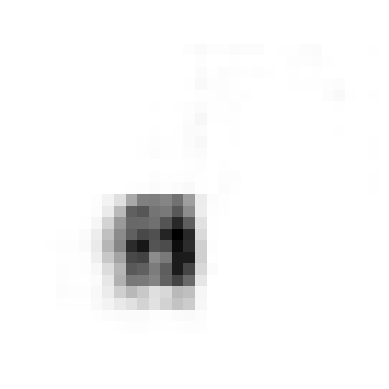

tf.Tensor([0.15873016 0.         0.6666667  0.6666667 ], shape=(4,), dtype=float32)
1/1 [==============================] - 0s 23ms/step


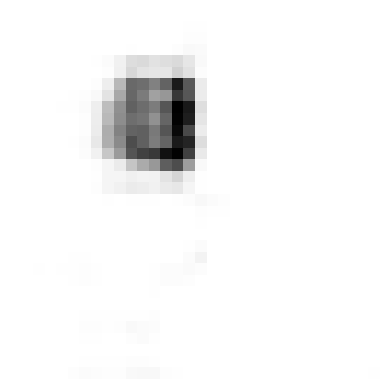

tf.Tensor([0.15873016 0.125      0.         0.        ], shape=(4,), dtype=float32)
1/1 [==============================] - 0s 23ms/step


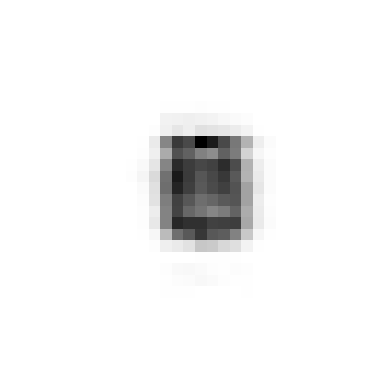

tf.Tensor([0.15873016 0.125      0.         0.33333334], shape=(4,), dtype=float32)
1/1 [==============================] - 0s 23ms/step


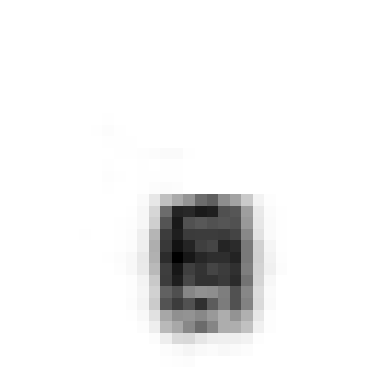

tf.Tensor([0.15873016 0.125      0.         0.6666667 ], shape=(4,), dtype=float32)
1/1 [==============================] - 0s 23ms/step


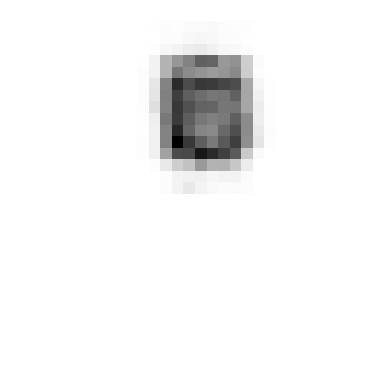

tf.Tensor([0.15873016 0.125      0.33333334 0.        ], shape=(4,), dtype=float32)
1/1 [==============================] - 0s 25ms/step


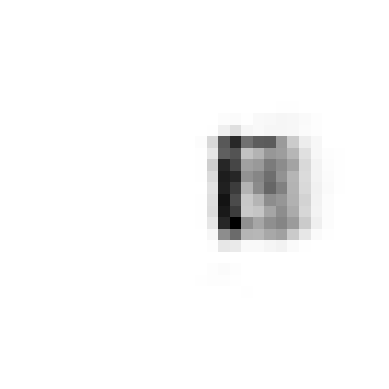

tf.Tensor([0.15873016 0.125      0.33333334 0.33333334], shape=(4,), dtype=float32)
1/1 [==============================] - 0s 22ms/step


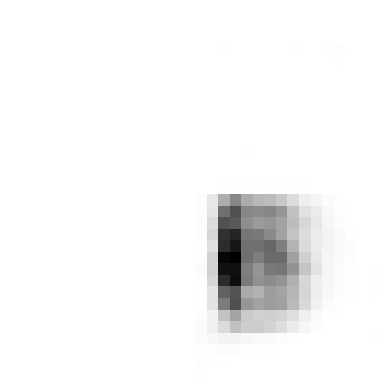

tf.Tensor([0.15873016 0.125      0.33333334 0.6666667 ], shape=(4,), dtype=float32)
1/1 [==============================] - 0s 22ms/step


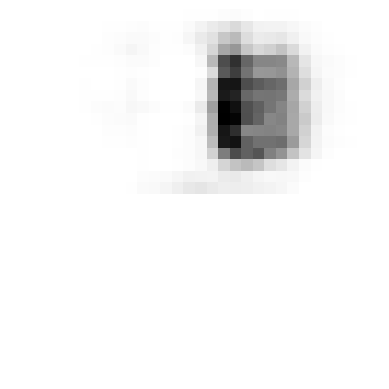

tf.Tensor([0.15873016 0.125      0.6666667  0.        ], shape=(4,), dtype=float32)
1/1 [==============================] - 0s 27ms/step


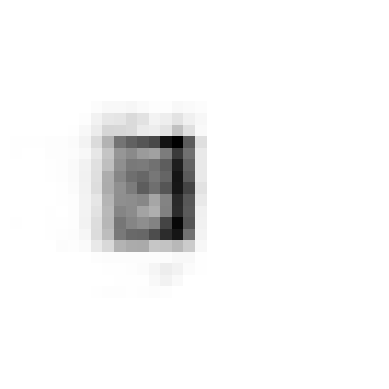

tf.Tensor([0.15873016 0.125      0.6666667  0.33333334], shape=(4,), dtype=float32)
1/1 [==============================] - 0s 23ms/step


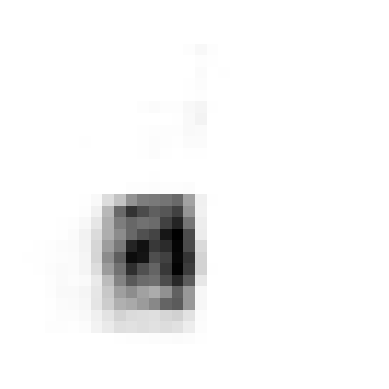

tf.Tensor([0.15873016 0.125      0.6666667  0.6666667 ], shape=(4,), dtype=float32)
1/1 [==============================] - 0s 23ms/step


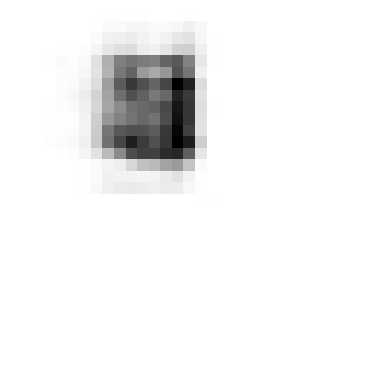

tf.Tensor([0.15873016 0.25       0.         0.        ], shape=(4,), dtype=float32)
1/1 [==============================] - 0s 27ms/step


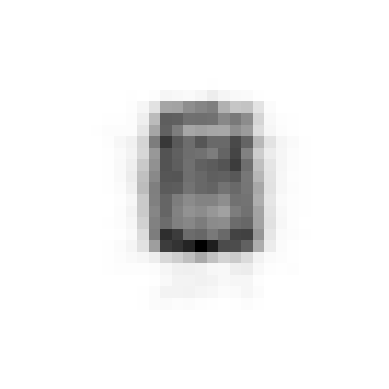

tf.Tensor([0.15873016 0.25       0.         0.33333334], shape=(4,), dtype=float32)
1/1 [==============================] - 0s 30ms/step


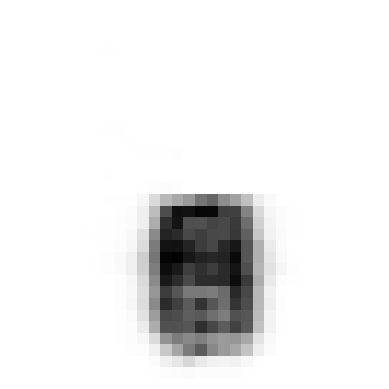

tf.Tensor([0.15873016 0.25       0.         0.6666667 ], shape=(4,), dtype=float32)
1/1 [==============================] - 0s 28ms/step


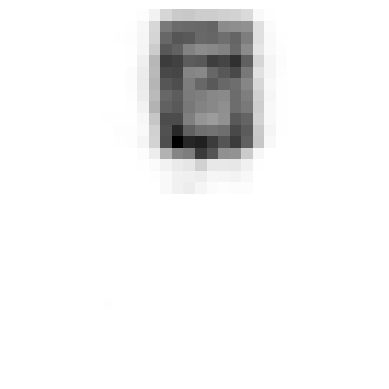

tf.Tensor([0.15873016 0.25       0.33333334 0.        ], shape=(4,), dtype=float32)
1/1 [==============================] - 0s 23ms/step


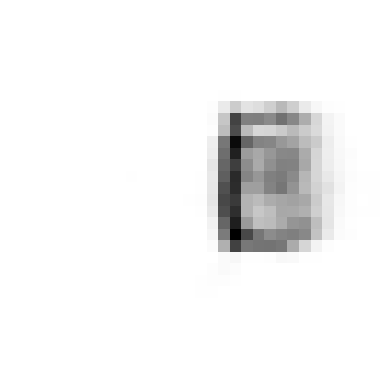

tf.Tensor([0.15873016 0.25       0.33333334 0.33333334], shape=(4,), dtype=float32)
1/1 [==============================] - 0s 24ms/step


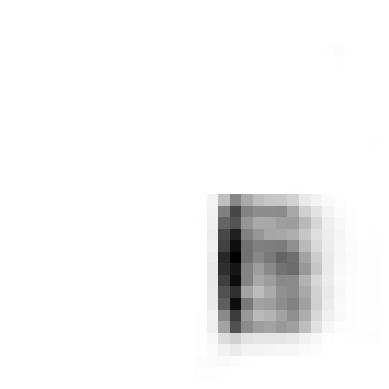

tf.Tensor([0.15873016 0.25       0.33333334 0.6666667 ], shape=(4,), dtype=float32)
1/1 [==============================] - 0s 22ms/step


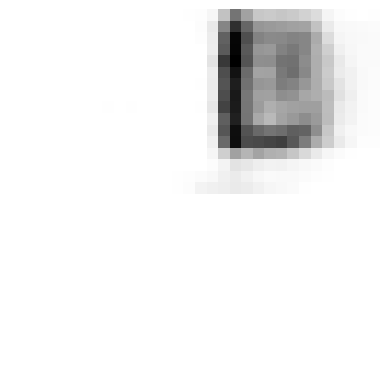

tf.Tensor([0.15873016 0.25       0.6666667  0.        ], shape=(4,), dtype=float32)
1/1 [==============================] - 0s 25ms/step


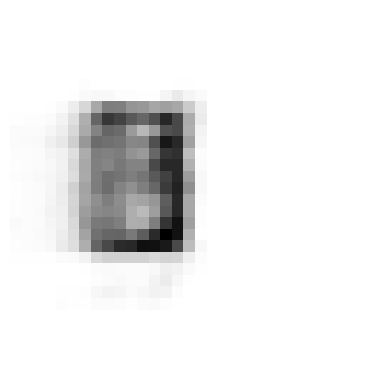

tf.Tensor([0.15873016 0.25       0.6666667  0.33333334], shape=(4,), dtype=float32)
1/1 [==============================] - 0s 22ms/step


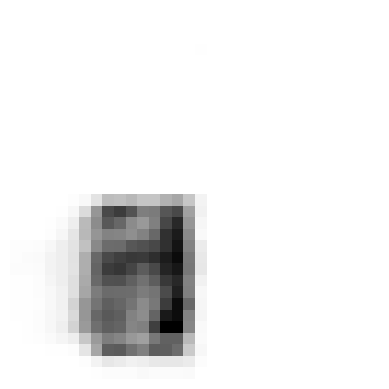

tf.Tensor([0.15873016 0.25       0.6666667  0.6666667 ], shape=(4,), dtype=float32)
1/1 [==============================] - 0s 23ms/step


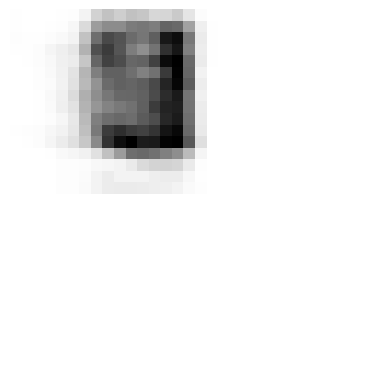

tf.Tensor([0.15873016 0.375      0.         0.        ], shape=(4,), dtype=float32)
1/1 [==============================] - 0s 28ms/step


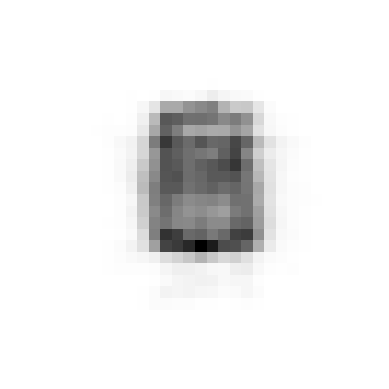

tf.Tensor([0.15873016 0.375      0.         0.33333334], shape=(4,), dtype=float32)
1/1 [==============================] - 0s 25ms/step


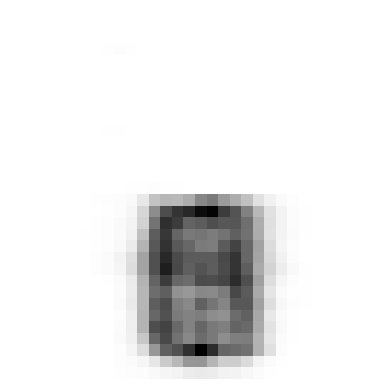

tf.Tensor([0.15873016 0.375      0.         0.6666667 ], shape=(4,), dtype=float32)
1/1 [==============================] - 0s 28ms/step


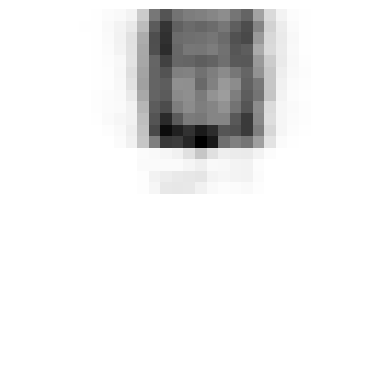

tf.Tensor([0.15873016 0.375      0.33333334 0.        ], shape=(4,), dtype=float32)
1/1 [==============================] - 0s 23ms/step


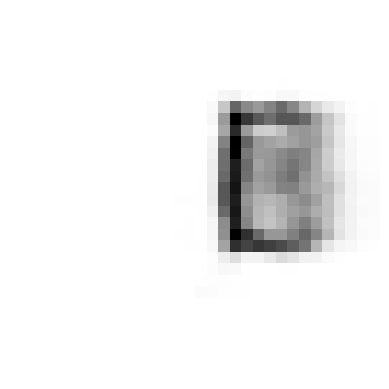

tf.Tensor([0.15873016 0.375      0.33333334 0.33333334], shape=(4,), dtype=float32)
1/1 [==============================] - 0s 54ms/step


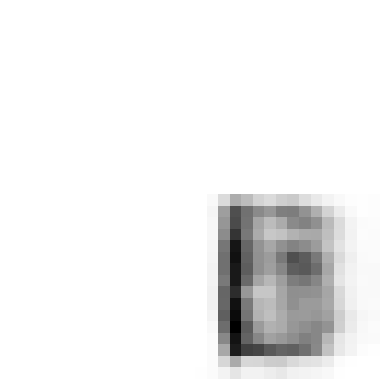

tf.Tensor([0.15873016 0.375      0.33333334 0.6666667 ], shape=(4,), dtype=float32)
1/1 [==============================] - 0s 25ms/step


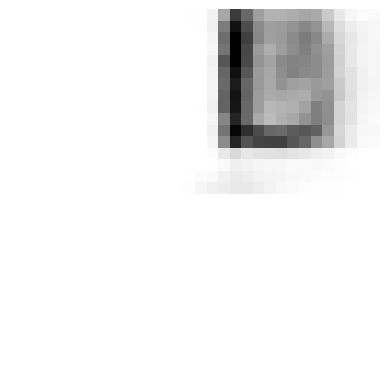

tf.Tensor([0.15873016 0.375      0.6666667  0.        ], shape=(4,), dtype=float32)
1/1 [==============================] - 0s 23ms/step


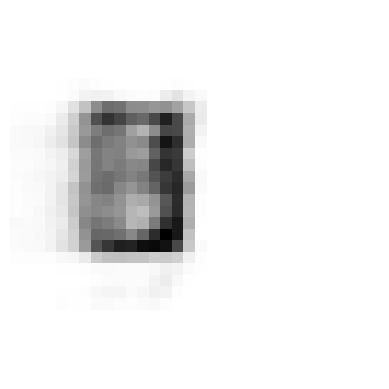

tf.Tensor([0.15873016 0.375      0.6666667  0.33333334], shape=(4,), dtype=float32)
1/1 [==============================] - 0s 25ms/step


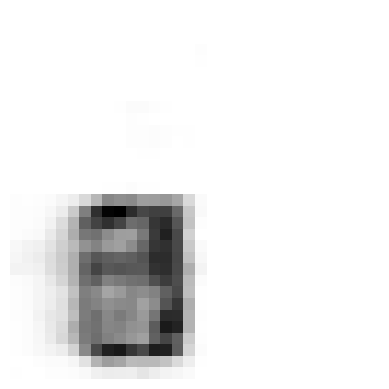

tf.Tensor([0.15873016 0.375      0.6666667  0.6666667 ], shape=(4,), dtype=float32)
1/1 [==============================] - 0s 27ms/step


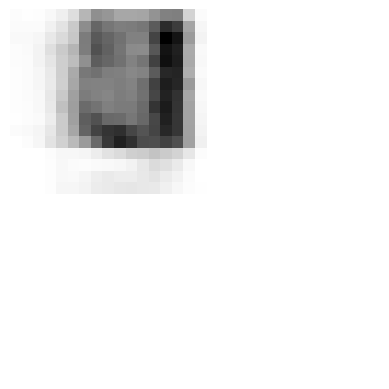

tf.Tensor([0.15873016 0.5        0.         0.        ], shape=(4,), dtype=float32)
1/1 [==============================] - 0s 25ms/step


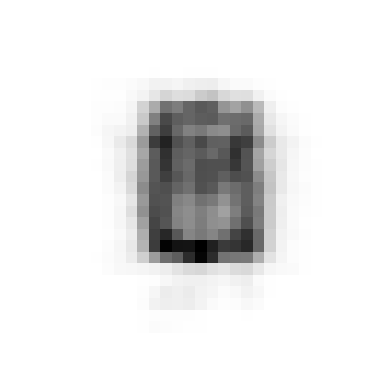

tf.Tensor([0.15873016 0.5        0.         0.33333334], shape=(4,), dtype=float32)
1/1 [==============================] - 0s 25ms/step


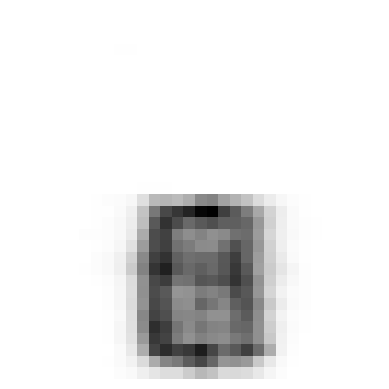

tf.Tensor([0.15873016 0.5        0.         0.6666667 ], shape=(4,), dtype=float32)
1/1 [==============================] - 0s 37ms/step


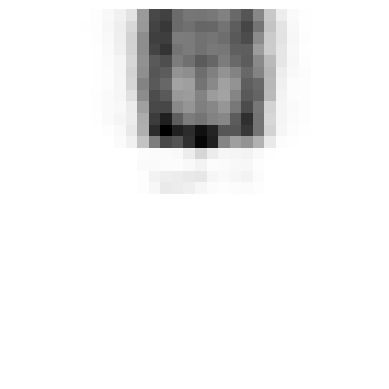

tf.Tensor([0.15873016 0.5        0.33333334 0.        ], shape=(4,), dtype=float32)
1/1 [==============================] - 0s 25ms/step


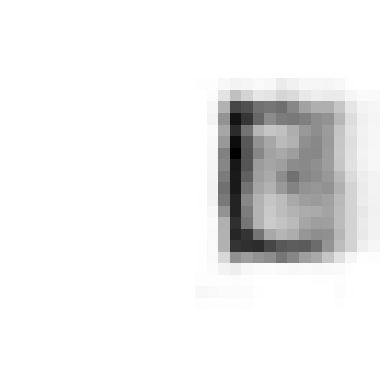

tf.Tensor([0.15873016 0.5        0.33333334 0.33333334], shape=(4,), dtype=float32)
1/1 [==============================] - 0s 25ms/step


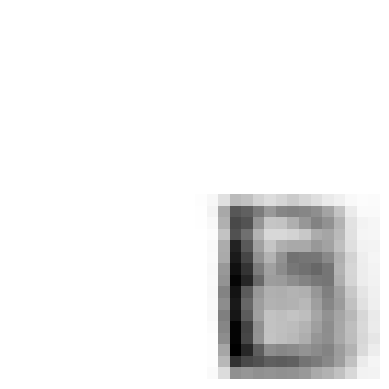

tf.Tensor([0.15873016 0.5        0.33333334 0.6666667 ], shape=(4,), dtype=float32)
1/1 [==============================] - 0s 24ms/step


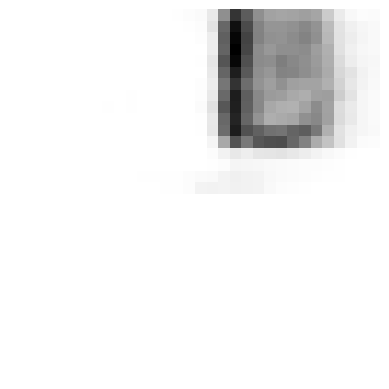

tf.Tensor([0.15873016 0.5        0.6666667  0.        ], shape=(4,), dtype=float32)
1/1 [==============================] - 0s 26ms/step


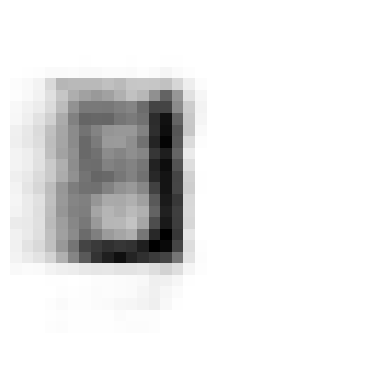

tf.Tensor([0.15873016 0.5        0.6666667  0.33333334], shape=(4,), dtype=float32)
1/1 [==============================] - 0s 25ms/step


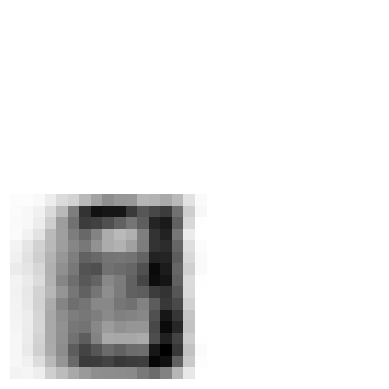

tf.Tensor([0.15873016 0.5        0.6666667  0.6666667 ], shape=(4,), dtype=float32)
1/1 [==============================] - 0s 23ms/step


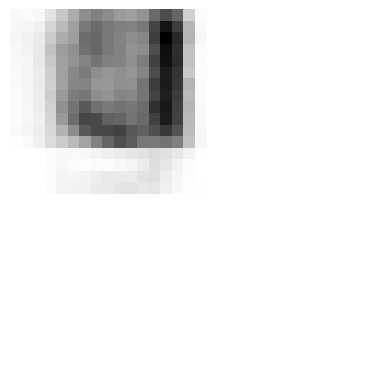

tf.Tensor([0.15873016 0.625      0.         0.        ], shape=(4,), dtype=float32)
1/1 [==============================] - 0s 26ms/step


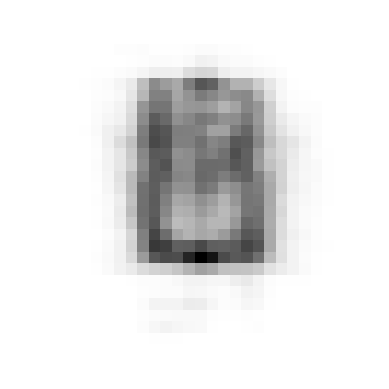

tf.Tensor([0.15873016 0.625      0.         0.33333334], shape=(4,), dtype=float32)
1/1 [==============================] - 0s 23ms/step


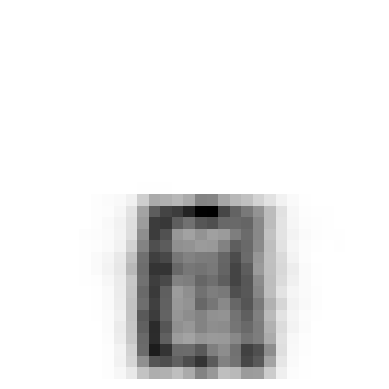

tf.Tensor([0.15873016 0.625      0.         0.6666667 ], shape=(4,), dtype=float32)
1/1 [==============================] - 0s 25ms/step


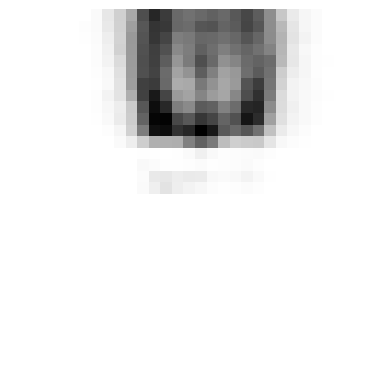

In [157]:
for input_ds, output_ds in dataset.skip(5).take(1):
    for i, el in enumerate(input_ds):
#         if i > 5: break
        print(el)
        plt.imshow(vae.predict(el[np.newaxis, :])[0], cmap='gray')
        plt.axis("off")
        plt.show()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_15 (InputLayer)       [(None, 4)]                  0         []                            
                                                                                                  
 dense_30 (Dense)            (None, 64)                   320       ['input_15[0][0]']            
                                                                                                  
 batch_normalization_17 (Ba  (None, 64)                   256       ['dense_30[0][0]']            
 tchNormalization)                                                                                
                                                                                                  
 activation_17 (Activation)  (None, 64)                   0         ['batch_normalization_17

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 2)]               0         
                                                                 
 dense_34 (Dense)            (None, 4096)              12288     
                                                                 
 reshape_6 (Reshape)         (None, 8, 8, 64)          0         
                                                                 
 conv2d_transpose_2 (Conv2D  (None, 16, 16, 64)        36928     
 Transpose)                                                      
                                                                 
 conv2d_transpose_3 (Conv2D  (None, 32, 32, 32)        18464     
 Transpose)                                                      
                                                                 
 conv2d_transpose_4 (Conv2D  (None, 32, 32, 1)         289 